In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.optimizers import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import cv2
import h5py
import os
import random

import warnings
warnings.filterwarnings("ignore")

# Create Pairs

In [2]:
ground_truth = pd.read_csv('.\COMP90086_2023_TLLdataset\\train_augmented.csv')

# Create a dictionary for lookup
gt_dict = ground_truth.set_index('left').to_dict()['right']

def create_training_dataset(left_folder, right_folder, ground_truth, num_foils=5, seed=123):
    random.seed(seed)
    left_images = [img_name.replace('.jpg', '') for img_name in os.listdir(left_folder)]
    right_images = [img_name.replace('.jpg', '') for img_name in os.listdir(right_folder)]

    paired_data = []
    labels = []

    for left_img_name in left_images:
        true_match = ground_truth[left_img_name]

        foils = [img for img in right_images if img != true_match]
        random.shuffle(foils)
        foils = foils[:num_foils]

        paired_data.append((left_img_name, true_match))
        labels.append(1)  # 1 indicates a true match

        for foil in foils:
            paired_data.append((left_img_name, foil))
            labels.append(0)  # 0 indicates a non-match

    return paired_data, labels

# Creating paired data and labels
paired_data, labels = create_training_dataset(".\COMP90086_2023_TLLdataset\\train\\left_augmented",
                                              ".\COMP90086_2023_TLLdataset\\train\\right",
                                              gt_dict)

labels = np.array(labels)

# L1 Distance

## vgg

In [3]:
left_train = np.load('vgg_train_left.npy')
left_train_augmented = np.load('AUG_vgg_train_left.npy')
left_train = np.concatenate((left_train, left_train_augmented))
right_train = np.load('vgg_train_right.npy')
left_test = np.load('vgg_test_left.npy')
right_test = np.load('vgg_test_right.npy')

# left_train = np.load('resnet_train_left.npy')
# left_train_augmented = np.load('AUG_resnet_train_left.npy')
# left_train = np.concatenate((left_train, left_train_augmented))
# right_train = np.load('resnet_train_right.npy')
# left_test = np.load('resnet_test_left.npy')
# right_test = np.load('resnet_test_right.npy')

# left_train = np.load('densenet_train_left.npy')
# left_train_augmented = np.load('AUG_densenet_train_left.npy')
# left_train = np.concatenate((left_train, left_train_augmented))
# right_train = np.load('densenet_train_right.npy')
# left_test = np.load('densenet_test_left.npy')
# right_test = np.load('densenet_test_right.npy')

In [4]:
left_array_dict = {}
right_array_dict = {}
for i in range(len(ground_truth)):
    left_array_dict[ground_truth['left'][i]] = left_train[i]
    if i%4 == 0:
        right_array_dict[ground_truth['right'][i//4]] = right_train[i//4]

pairs_for_training = []
for i in range(len(paired_data)):
    pairs_for_training.append([left_array_dict.get(paired_data[i][0]) , right_array_dict.get(paired_data[i][1])])
    
pairs_for_training = np.array(pairs_for_training)

left_images = pairs_for_training[:, 0]
right_images = pairs_for_training[:, 1]



test_candidates = pd.read_csv('.\COMP90086_2023_TLLdataset\\test_candidates.csv')

path = ".\COMP90086_2023_TLLdataset\\test\\left"
dir_list = os.listdir(path)
test_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\test\\right"
dir_list = os.listdir(path)
test_right_images_list = dir_list

left_array_dict = {}
for i in range(len(test_left_images_list)):
    left_array_dict[test_left_images_list[i][:3]] = left_test[i]
    
right_array_dict = {}
for i in range(len(test_right_images_list)):
    right_array_dict[test_right_images_list[i][:3]] = right_test[i]
    
pairs_for_test = []
for j in range(len(test_candidates)):
    for i in range(20):
        pairs_for_test.append([left_array_dict.get(test_candidates.iloc[j][0]) , right_array_dict.get(test_candidates.iloc[j][i+1])])

pairs_for_test = np.array(pairs_for_test)

x_test_1 = pairs_for_test[:, 0]
x_test_2 = pairs_for_test[:, 1]

### batch size = 16, number of layer = 1

In [5]:
input_shape = (512,)
# input_shape = (2048,)
# input_shape = (1024,)

def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(64, activation='relu')
        
    ])
    
    return model

# Reference:
# https://keras.io/examples/vision/siamese_contrastive/?fbclid=IwAR0d0p7eAw2zZDUiyaPhkt-ZQuDQ32U7rRIHxv4ErsSn9yVkBFbfzBC42fQ
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

def create_siamese_network(input_shape):
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    shared_network = create_shared_network(input_shape)
    left_features = shared_network(left_input)
    right_features = shared_network(right_input)

    distance = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([left_features, right_features])
    normal_layer = tf.keras.layers.BatchNormalization()(distance)
    similarity_score = Dense(1, activation='sigmoid')(distance)
    
#     distance = Lambda(euclidean_distance)([left_features, right_features])
#     normal_layer = tf.keras.layers.BatchNormalization()(distance)
#     similarity_score = layers.Dense(1, activation="sigmoid")(normal_layer)

    siamese_net = Model(inputs=[left_input, right_input], outputs=1-similarity_score)
    return siamese_net
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L1_augmented\\vgg_{}_1_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L1_augmented\\vgg_{}_1_{}.png".format(batch_size, metric))
    plt.show()

In [6]:
# Reference:
# https://keras.io/examples/vision/siamese_contrastive/?fbclid=IwAR0d0p7eAw2zZDUiyaPhkt-ZQuDQ32U7rRIHxv4ErsSn9yVkBFbfzBC42fQ
def loss():
    margin=1
    def contrastive_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [7]:
batch_size = 16
no_layer = 1
lr = 0.001
model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

epochs = 100
history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
2400/2400 - 3s - loss: 0.1408 - accuracy: 0.8338 - recall: 0.0103 - val_loss: 0.1493 - val_accuracy: 0.8331 - val_recall: 0.0019
Epoch 2/100
2400/2400 - 3s - loss: 0.1190 - accuracy: 0.8493 - recall: 0.1491 - val_loss: 0.1626 - val_accuracy: 0.8247 - val_recall: 0.0069
Epoch 3/100
2400/2400 - 3s - loss: 0.0926 - accuracy: 0.8853 - recall: 0.4170 - val_loss: 0.1720 - val_accuracy: 0.8110 - val_recall: 0.0150
Epoch 4/100
2400/2400 - 3s - loss: 0.0714 - accuracy: 0.9174 - recall: 0.6014 - val_loss: 0.1777 - val_accuracy: 0.8076 - val_recall: 0.0206
Epoch 5/100
2400/2400 - 3s - loss: 0.0576 - accuracy: 0.9351 - recall: 0.6911 - val_loss: 0.1812 - val_accuracy: 0.8033 - val_recall: 0.0162
Epoch 6/100
2400/2400 - 3s - loss: 0.0492 - accuracy: 0.9449 - recall: 0.7391 - val_loss: 0.1822 - val_accuracy: 0.8054 - val_recall: 0.0188
Epoch 7/100
2400/2400 - 3s - loss: 0.0432 - accuracy: 0.9524 - recall: 0.7713 - val_loss: 0.2007 - val_accuracy: 0.7770 - val_recall: 0.0281
Epoch 8/100
2

Epoch 59/100
2400/2400 - 2s - loss: 0.0257 - accuracy: 0.9735 - recall: 0.8531 - val_loss: 0.2022 - val_accuracy: 0.7927 - val_recall: 0.0256
Epoch 60/100
2400/2400 - 2s - loss: 0.0257 - accuracy: 0.9734 - recall: 0.8509 - val_loss: 0.2009 - val_accuracy: 0.7939 - val_recall: 0.0231
Epoch 61/100
2400/2400 - 2s - loss: 0.0261 - accuracy: 0.9729 - recall: 0.8500 - val_loss: 0.2016 - val_accuracy: 0.7936 - val_recall: 0.0231
Epoch 62/100
2400/2400 - 3s - loss: 0.0256 - accuracy: 0.9737 - recall: 0.8523 - val_loss: 0.2048 - val_accuracy: 0.7892 - val_recall: 0.0319
Epoch 63/100
2400/2400 - 3s - loss: 0.0261 - accuracy: 0.9729 - recall: 0.8503 - val_loss: 0.1943 - val_accuracy: 0.8008 - val_recall: 0.0213
Epoch 64/100
2400/2400 - 3s - loss: 0.0258 - accuracy: 0.9735 - recall: 0.8528 - val_loss: 0.2002 - val_accuracy: 0.7953 - val_recall: 0.0275
Epoch 65/100
2400/2400 - 3s - loss: 0.0260 - accuracy: 0.9732 - recall: 0.8512 - val_loss: 0.1973 - val_accuracy: 0.7985 - val_recall: 0.0288
Epoch 

#### Predict

In [8]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

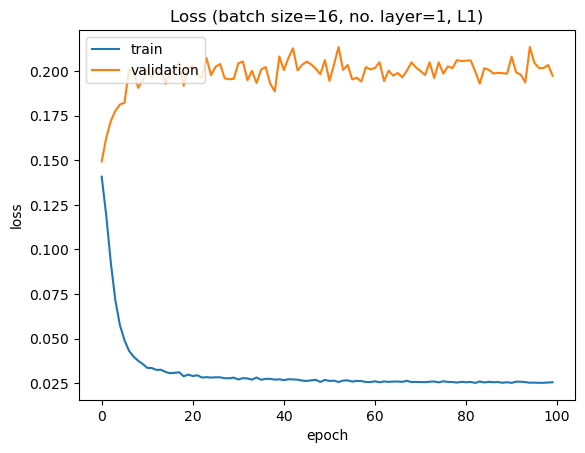

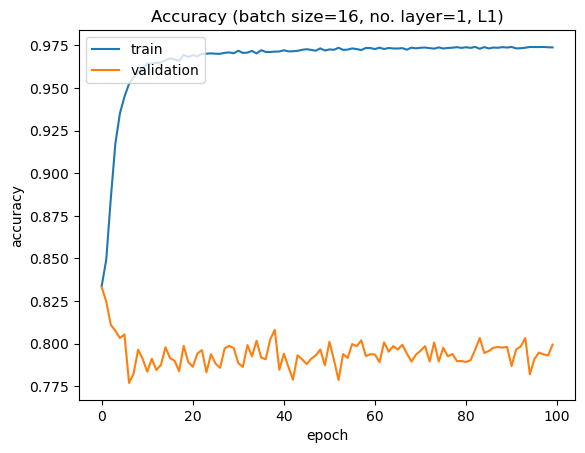

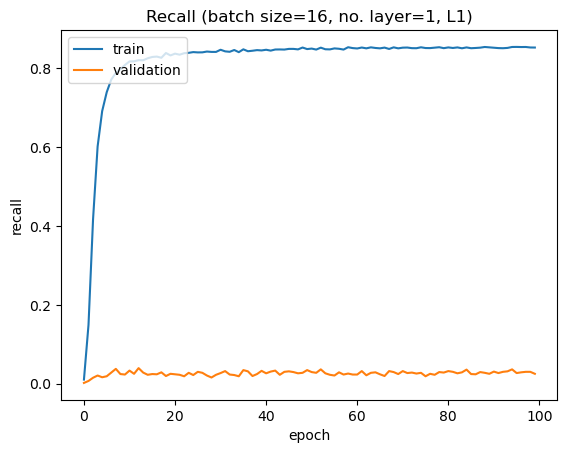

In [9]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [10]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.026
Training Accuracy: 0.974
Training Recall: 0.852


Validation Loss: 0.197
Validation Accuracy: 0.799
Validation Recall: 0.025


### batch size = 32, number of layer = 1

In [11]:
batch_size = 32
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
1200/1200 - 2s - loss: 0.1396 - accuracy: 0.8333 - recall_1: 0.0113 - val_loss: 0.1496 - val_accuracy: 0.8332 - val_recall_1: 0.0025
Epoch 2/100
1200/1200 - 2s - loss: 0.1152 - accuracy: 0.8529 - recall_1: 0.1734 - val_loss: 0.1624 - val_accuracy: 0.8158 - val_recall_1: 0.0194
Epoch 3/100
1200/1200 - 2s - loss: 0.0890 - accuracy: 0.8928 - recall_1: 0.4431 - val_loss: 0.1745 - val_accuracy: 0.8018 - val_recall_1: 0.0288
Epoch 4/100
1200/1200 - 2s - loss: 0.0675 - accuracy: 0.9195 - recall_1: 0.6170 - val_loss: 0.1790 - val_accuracy: 0.8002 - val_recall_1: 0.0169
Epoch 5/100
1200/1200 - 2s - loss: 0.0528 - accuracy: 0.9404 - recall_1: 0.7173 - val_loss: 0.1818 - val_accuracy: 0.7993 - val_recall_1: 0.0237
Epoch 6/100
1200/1200 - 2s - loss: 0.0421 - accuracy: 0.9544 - recall_1: 0.7837 - val_loss: 0.1880 - val_accuracy: 0.7931 - val_recall_1: 0.0181
Epoch 7/100
1200/1200 - 2s - loss: 0.0363 - accuracy: 0.9614 - recall_1: 0.8142 - val_loss: 0.1896 - val_accuracy: 0.7929 - val_re

Epoch 58/100
1200/1200 - 2s - loss: 0.0194 - accuracy: 0.9798 - recall_1: 0.8883 - val_loss: 0.1932 - val_accuracy: 0.8019 - val_recall_1: 0.0213
Epoch 59/100
1200/1200 - 2s - loss: 0.0191 - accuracy: 0.9803 - recall_1: 0.8895 - val_loss: 0.1984 - val_accuracy: 0.7947 - val_recall_1: 0.0244
Epoch 60/100
1200/1200 - 2s - loss: 0.0190 - accuracy: 0.9807 - recall_1: 0.8919 - val_loss: 0.1948 - val_accuracy: 0.7987 - val_recall_1: 0.0237
Epoch 61/100
1200/1200 - 3s - loss: 0.0189 - accuracy: 0.9804 - recall_1: 0.8903 - val_loss: 0.1955 - val_accuracy: 0.7992 - val_recall_1: 0.0294
Epoch 62/100
1200/1200 - 2s - loss: 0.0194 - accuracy: 0.9798 - recall_1: 0.8880 - val_loss: 0.2005 - val_accuracy: 0.7933 - val_recall_1: 0.0237
Epoch 63/100
1200/1200 - 2s - loss: 0.0197 - accuracy: 0.9797 - recall_1: 0.8883 - val_loss: 0.1977 - val_accuracy: 0.7959 - val_recall_1: 0.0225
Epoch 64/100
1200/1200 - 2s - loss: 0.0188 - accuracy: 0.9805 - recall_1: 0.8917 - val_loss: 0.1953 - val_accuracy: 0.7994 -

#### Predict

In [12]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

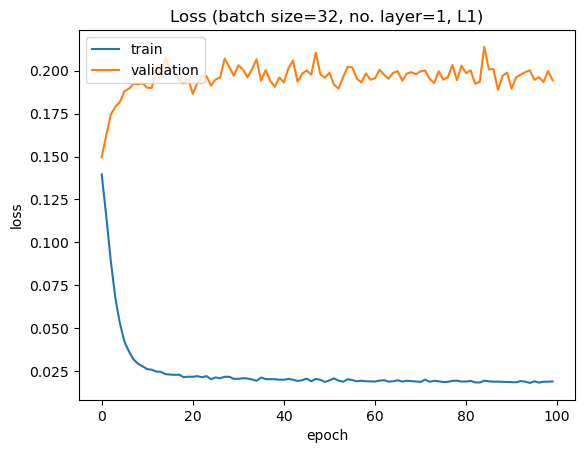

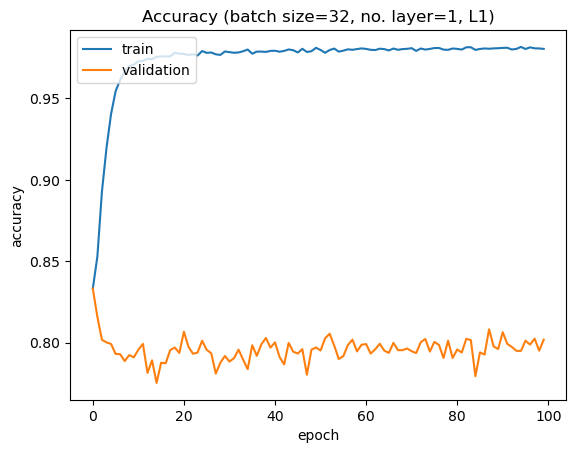

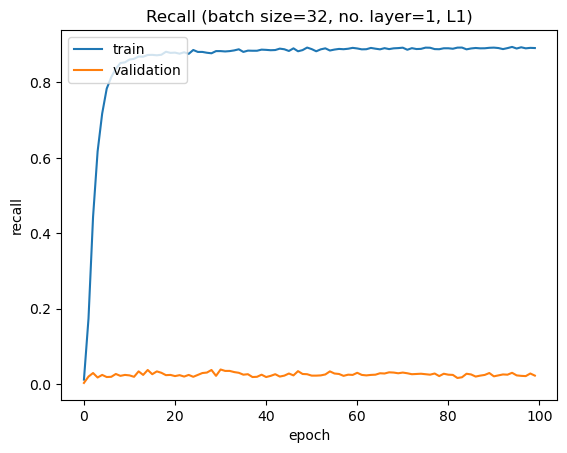

In [13]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [14]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.019
Training Accuracy: 0.98
Training Recall: 0.891


Validation Loss: 0.194
Validation Accuracy: 0.802
Validation Recall: 0.022


### batch size = 64, number of layer = 1

In [15]:
batch_size = 64
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.1389 - accuracy: 0.8339 - recall_2: 0.0095 - val_loss: 0.1496 - val_accuracy: 0.8327 - val_recall_2: 6.2500e-04
Epoch 2/100
600/600 - 1s - loss: 0.1142 - accuracy: 0.8543 - recall_2: 0.1630 - val_loss: 0.1641 - val_accuracy: 0.8133 - val_recall_2: 0.0194
Epoch 3/100
600/600 - 1s - loss: 0.0848 - accuracy: 0.8977 - recall_2: 0.4584 - val_loss: 0.1761 - val_accuracy: 0.7953 - val_recall_2: 0.0250
Epoch 4/100
600/600 - 1s - loss: 0.0623 - accuracy: 0.9308 - recall_2: 0.6559 - val_loss: 0.1784 - val_accuracy: 0.8026 - val_recall_2: 0.0181
Epoch 5/100
600/600 - 1s - loss: 0.0463 - accuracy: 0.9520 - recall_2: 0.7647 - val_loss: 0.1838 - val_accuracy: 0.7960 - val_recall_2: 0.0175
Epoch 6/100
600/600 - 1s - loss: 0.0368 - accuracy: 0.9643 - recall_2: 0.8198 - val_loss: 0.1814 - val_accuracy: 0.8037 - val_recall_2: 0.0162
Epoch 7/100
600/600 - 1s - loss: 0.0311 - accuracy: 0.9691 - recall_2: 0.8441 - val_loss: 0.1936 - val_accuracy: 0.7854 - val_recall_2: 0.

Epoch 58/100
600/600 - 1s - loss: 0.0165 - accuracy: 0.9831 - recall_2: 0.9045 - val_loss: 0.2050 - val_accuracy: 0.7890 - val_recall_2: 0.0312
Epoch 59/100
600/600 - 1s - loss: 0.0166 - accuracy: 0.9829 - recall_2: 0.9039 - val_loss: 0.2000 - val_accuracy: 0.7930 - val_recall_2: 0.0262
Epoch 60/100
600/600 - 1s - loss: 0.0168 - accuracy: 0.9827 - recall_2: 0.9042 - val_loss: 0.2082 - val_accuracy: 0.7845 - val_recall_2: 0.0281
Epoch 61/100
600/600 - 1s - loss: 0.0167 - accuracy: 0.9827 - recall_2: 0.9036 - val_loss: 0.2011 - val_accuracy: 0.7915 - val_recall_2: 0.0256
Epoch 62/100
600/600 - 1s - loss: 0.0163 - accuracy: 0.9833 - recall_2: 0.9053 - val_loss: 0.2022 - val_accuracy: 0.7895 - val_recall_2: 0.0231
Epoch 63/100
600/600 - 1s - loss: 0.0155 - accuracy: 0.9845 - recall_2: 0.9089 - val_loss: 0.1982 - val_accuracy: 0.7954 - val_recall_2: 0.0231
Epoch 64/100
600/600 - 1s - loss: 0.0172 - accuracy: 0.9823 - recall_2: 0.9011 - val_loss: 0.2057 - val_accuracy: 0.7871 - val_recall_2:

#### Predict

In [16]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

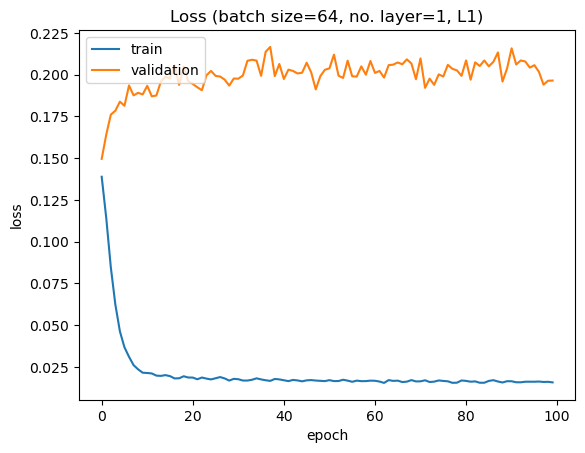

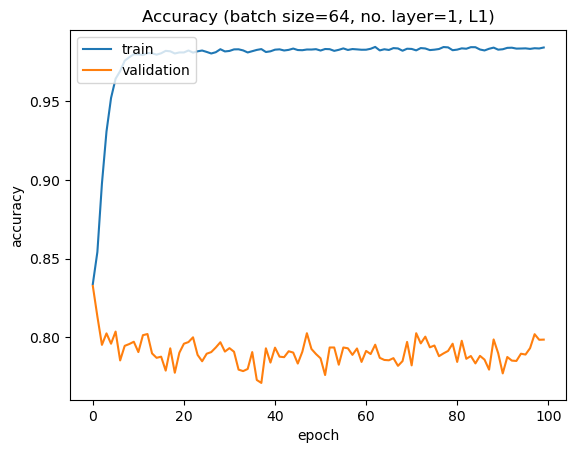

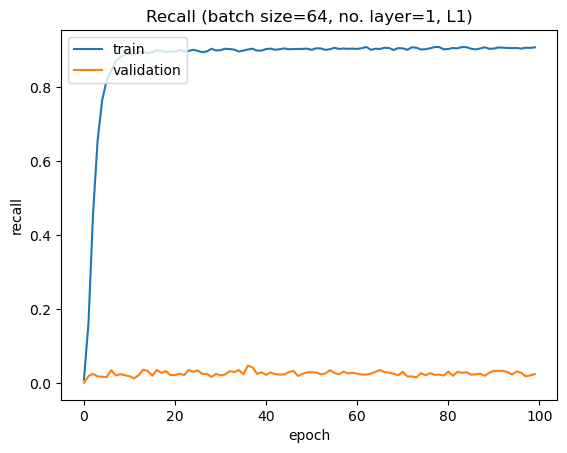

In [17]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [18]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.016
Training Accuracy: 0.984
Training Recall: 0.908


Validation Loss: 0.196
Validation Accuracy: 0.799
Validation Recall: 0.024


### batch size = 16, number of layer = 2

In [19]:
def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),
        
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu')
        
    ])
    
    return model

def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L1_augmented\\vgg_{}_2_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L1_augmented\\vgg_{}_2_{}.png".format(batch_size, metric))
    plt.show()

In [20]:
batch_size = 16
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
2400/2400 - 4s - loss: 0.1668 - accuracy: 0.8329 - recall_3: 1.5625e-04 - val_loss: 0.1646 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00
Epoch 2/100
2400/2400 - 4s - loss: 0.1667 - accuracy: 0.8333 - recall_3: 3.1250e-04 - val_loss: 0.1650 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00
Epoch 3/100
2400/2400 - 4s - loss: 0.1667 - accuracy: 0.8333 - recall_3: 3.1250e-04 - val_loss: 0.1657 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00
Epoch 4/100
2400/2400 - 4s - loss: 0.1667 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1659 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00
Epoch 5/100
2400/2400 - 4s - loss: 0.1667 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1659 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00
Epoch 6/100
2400/2400 - 4s - loss: 0.1667 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1660 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00
Epoch 7/100
2400/2400 - 4s - loss: 0.1667 - accuracy: 0.8333 - recall_3: 0.0000e+0

Epoch 54/100
2400/2400 - 3s - loss: 0.1667 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00
Epoch 55/100
2400/2400 - 3s - loss: 0.1667 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00
Epoch 56/100
2400/2400 - 3s - loss: 0.1667 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00
Epoch 57/100
2400/2400 - 3s - loss: 0.1667 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00
Epoch 58/100
2400/2400 - 3s - loss: 0.1667 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00
Epoch 59/100
2400/2400 - 4s - loss: 0.1667 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00
Epoch 60/100
2400/2400 - 3s - loss: 0.1667 - accuracy: 0.8333 - recall_3: 0.

#### Predict

In [21]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

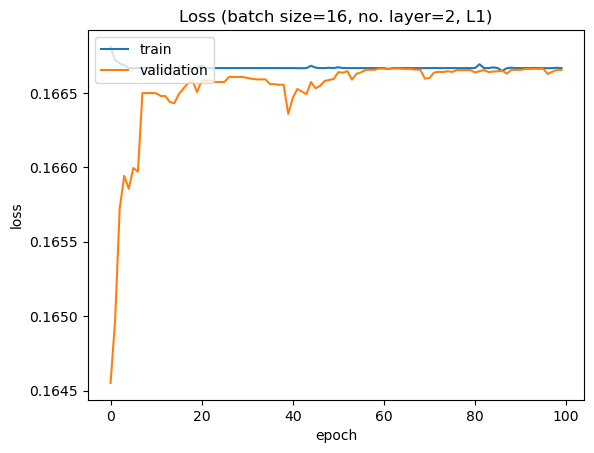

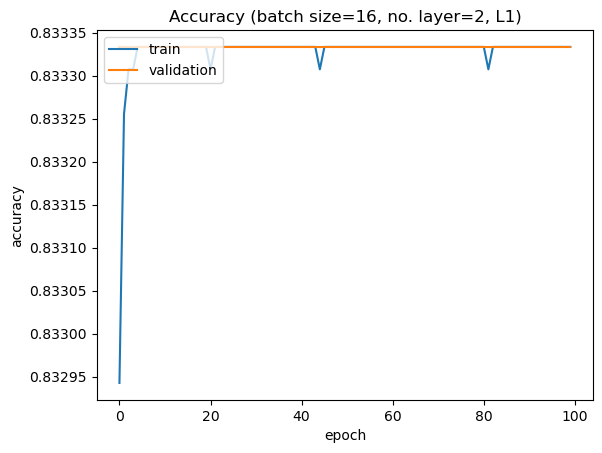

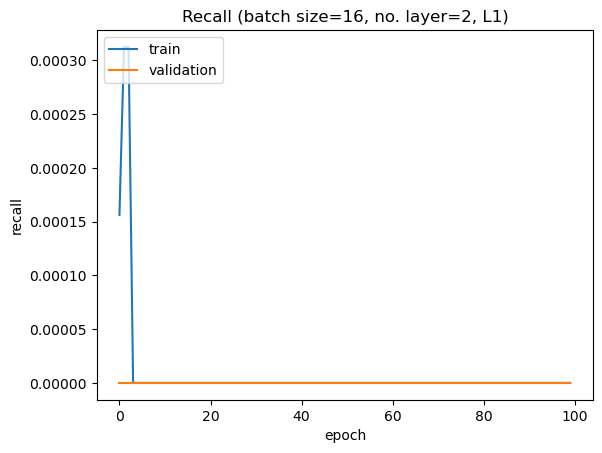

In [22]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [23]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.167
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.167
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 32, number of layer = 2

In [24]:
batch_size = 32
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
1200/1200 - 2s - loss: 0.1519 - accuracy: 0.8303 - recall_4: 0.0039 - val_loss: 0.1736 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00
Epoch 2/100
1200/1200 - 2s - loss: 0.1432 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1581 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00
Epoch 3/100
1200/1200 - 2s - loss: 0.1412 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1468 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00
Epoch 4/100
1200/1200 - 2s - loss: 0.1401 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1431 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00
Epoch 5/100
1200/1200 - 2s - loss: 0.1398 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1418 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00
Epoch 6/100
1200/1200 - 2s - loss: 0.1394 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1398 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00
Epoch 7/100
1200/1200 - 2s - loss: 0.1392 - accuracy: 0.8333 - recall_4: 0.0000e+00 - 

Epoch 55/100
1200/1200 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00
Epoch 56/100
1200/1200 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00
Epoch 57/100
1200/1200 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00
Epoch 58/100
1200/1200 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00
Epoch 59/100
1200/1200 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00
Epoch 60/100
1200/1200 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00
Epoch 61/100
1200/1200 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_4: 0.

#### Predict

In [25]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

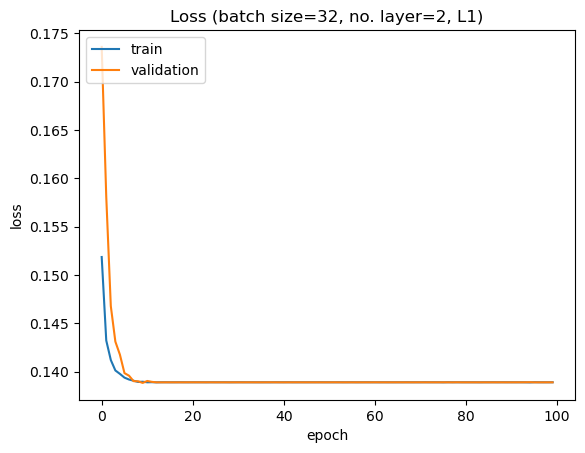

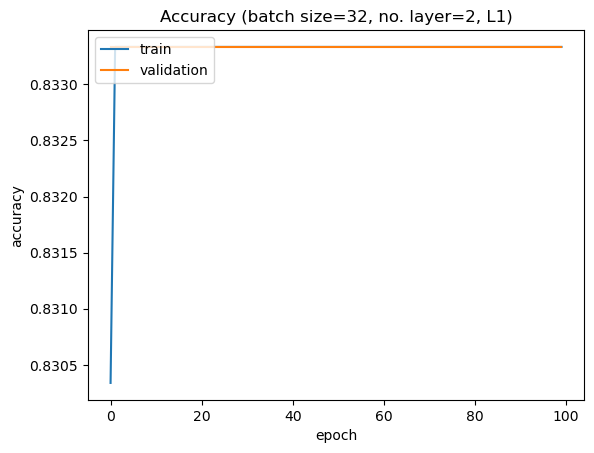

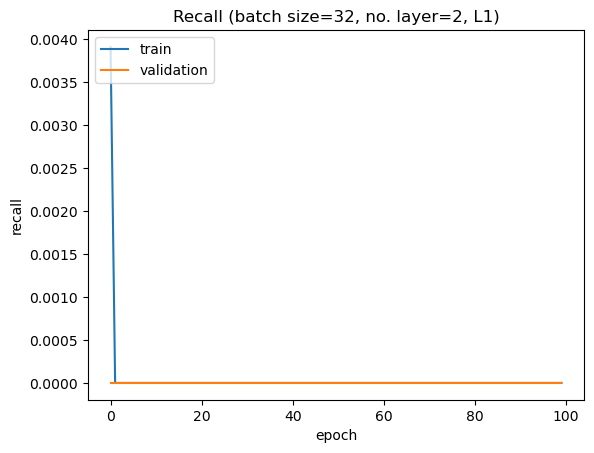

In [26]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [27]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.139
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.139
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 64, number of layer = 2

In [28]:
batch_size = 64
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 1s - loss: 0.1530 - accuracy: 0.8305 - recall_5: 0.0055 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00
Epoch 2/100
600/600 - 1s - loss: 0.1437 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1654 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00
Epoch 3/100
600/600 - 1s - loss: 0.1423 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1613 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00
Epoch 4/100
600/600 - 1s - loss: 0.1412 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1502 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00
Epoch 5/100
600/600 - 1s - loss: 0.1409 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1441 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00
Epoch 6/100
600/600 - 1s - loss: 0.1401 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1442 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00
Epoch 7/100
600/600 - 1s - loss: 0.1399 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.14

Epoch 55/100
600/600 - 1s - loss: 0.1385 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1406 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00
Epoch 56/100
600/600 - 1s - loss: 0.1385 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1405 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00
Epoch 57/100
600/600 - 1s - loss: 0.1385 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1409 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00
Epoch 58/100
600/600 - 1s - loss: 0.1384 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1412 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00
Epoch 59/100
600/600 - 1s - loss: 0.1384 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1407 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00
Epoch 60/100
600/600 - 1s - loss: 0.1385 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1410 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00
Epoch 61/100
600/600 - 1s - loss: 0.1384 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val

#### Predict

In [29]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

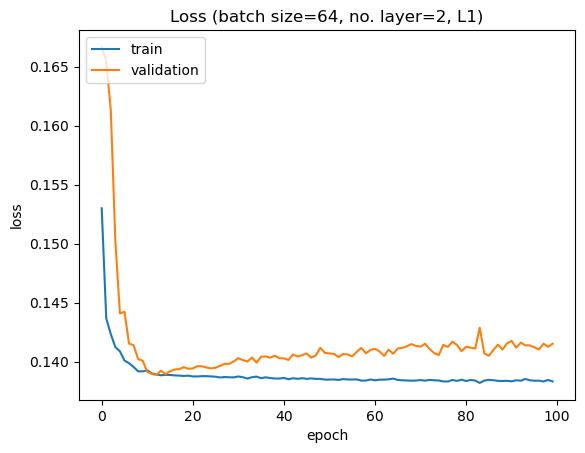

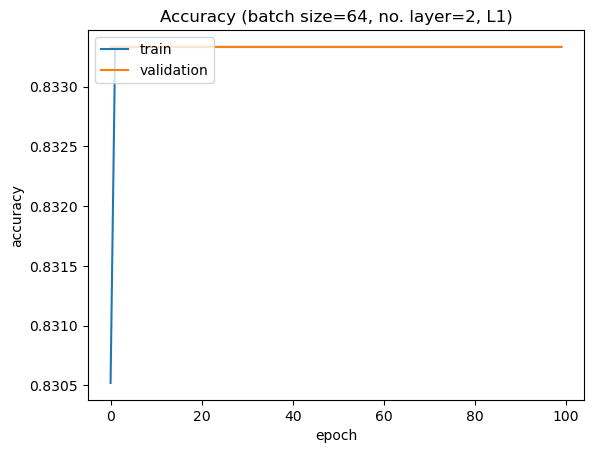

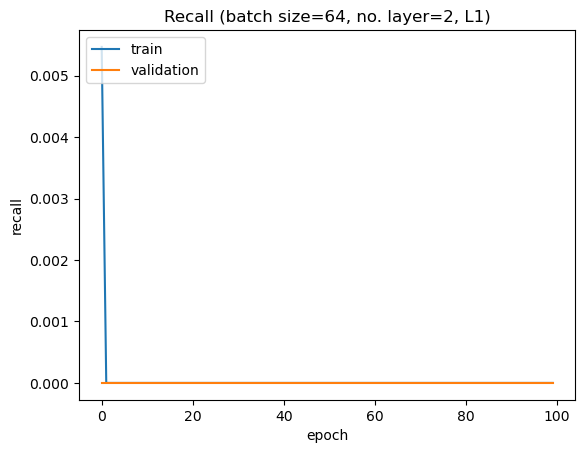

In [30]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [31]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.138
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.142
Validation Accuracy: 0.833
Validation Recall: 0.0


## resnet

In [32]:
# left_train = np.load('vgg_train_left.npy')
# left_train_augmented = np.load('AUG_vgg_train_left.npy')
# left_train = np.concatenate((left_train, left_train_augmented))
# right_train = np.load('vgg_train_right.npy')
# left_test = np.load('vgg_test_left.npy')
# right_test = np.load('vgg_test_right.npy')

left_train = np.load('resnet_train_left.npy')
left_train_augmented = np.load('AUG_resnet_train_left.npy')
left_train = np.concatenate((left_train, left_train_augmented))
right_train = np.load('resnet_train_right.npy')
left_test = np.load('resnet_test_left.npy')
right_test = np.load('resnet_test_right.npy')

# left_train = np.load('densenet_train_left.npy')
# left_train_augmented = np.load('AUG_densenet_train_left.npy')
# left_train = np.concatenate((left_train, left_train_augmented))
# right_train = np.load('densenet_train_right.npy')
# left_test = np.load('densenet_test_left.npy')
# right_test = np.load('densenet_test_right.npy')

In [33]:
left_array_dict = {}
right_array_dict = {}
for i in range(len(ground_truth)):
    left_array_dict[ground_truth['left'][i]] = left_train[i]
    if i%4 == 0:
        right_array_dict[ground_truth['right'][i//4]] = right_train[i//4]

pairs_for_training = []
for i in range(len(paired_data)):
    pairs_for_training.append([left_array_dict.get(paired_data[i][0]) , right_array_dict.get(paired_data[i][1])])
    
pairs_for_training = np.array(pairs_for_training)

left_images = pairs_for_training[:, 0]
right_images = pairs_for_training[:, 1]



test_candidates = pd.read_csv('.\COMP90086_2023_TLLdataset\\test_candidates.csv')

path = ".\COMP90086_2023_TLLdataset\\test\\left"
dir_list = os.listdir(path)
test_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\test\\right"
dir_list = os.listdir(path)
test_right_images_list = dir_list

left_array_dict = {}
for i in range(len(test_left_images_list)):
    left_array_dict[test_left_images_list[i][:3]] = left_test[i]
    
right_array_dict = {}
for i in range(len(test_right_images_list)):
    right_array_dict[test_right_images_list[i][:3]] = right_test[i]
    
pairs_for_test = []
for j in range(len(test_candidates)):
    for i in range(20):
        pairs_for_test.append([left_array_dict.get(test_candidates.iloc[j][0]) , right_array_dict.get(test_candidates.iloc[j][i+1])])

pairs_for_test = np.array(pairs_for_test)

x_test_1 = pairs_for_test[:, 0]
x_test_2 = pairs_for_test[:, 1]

### batch size = 16, number of layer = 1

In [34]:
# input_shape = (512,)
input_shape = (2048,)
# input_shape = (1024,)

def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(64, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L1_augmented\\resnet_{}_1_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L1_augmented\\resnet_{}_1_{}.png".format(batch_size, metric))
    plt.show()

In [35]:
batch_size = 16
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
2400/2400 - 6s - loss: 0.1667 - accuracy: 0.8331 - recall_6: 6.2500e-04 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_6: 0.0000e+00
Epoch 2/100
2400/2400 - 6s - loss: 0.1667 - accuracy: 0.8333 - recall_6: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_6: 0.0000e+00
Epoch 3/100
2400/2400 - 6s - loss: 0.1667 - accuracy: 0.8333 - recall_6: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_6: 0.0000e+00
Epoch 4/100
2400/2400 - 6s - loss: 0.1667 - accuracy: 0.8333 - recall_6: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_6: 0.0000e+00
Epoch 5/100
2400/2400 - 5s - loss: 0.1667 - accuracy: 0.8333 - recall_6: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_6: 0.0000e+00
Epoch 6/100
2400/2400 - 5s - loss: 0.1667 - accuracy: 0.8333 - recall_6: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_6: 0.0000e+00
Epoch 7/100
2400/2400 - 5s - loss: 0.1667 - accuracy: 0.8333 - recall_6: 0.0000e+0

Epoch 55/100
2400/2400 - 6s - loss: 0.1667 - accuracy: 0.8333 - recall_6: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_6: 0.0000e+00
Epoch 56/100
2400/2400 - 6s - loss: 0.1667 - accuracy: 0.8333 - recall_6: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_6: 0.0000e+00
Epoch 57/100
2400/2400 - 6s - loss: 0.1667 - accuracy: 0.8333 - recall_6: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_6: 0.0000e+00
Epoch 58/100
2400/2400 - 6s - loss: 0.1667 - accuracy: 0.8333 - recall_6: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_6: 0.0000e+00
Epoch 59/100
2400/2400 - 6s - loss: 0.1667 - accuracy: 0.8333 - recall_6: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_6: 0.0000e+00
Epoch 60/100
2400/2400 - 6s - loss: 0.1667 - accuracy: 0.8333 - recall_6: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_6: 0.0000e+00
Epoch 61/100
2400/2400 - 6s - loss: 0.1667 - accuracy: 0.8333 - recall_6: 0.

#### Predict

In [36]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

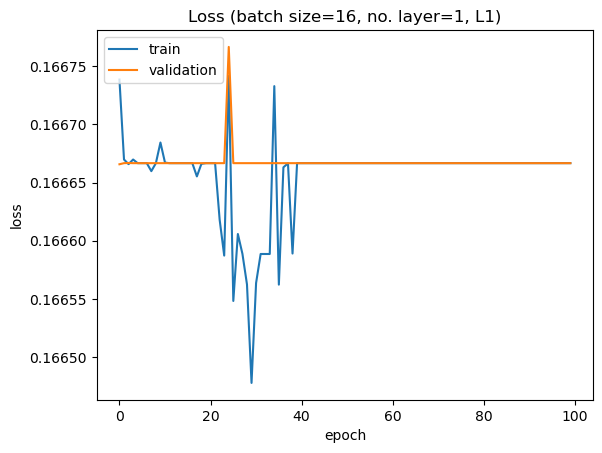

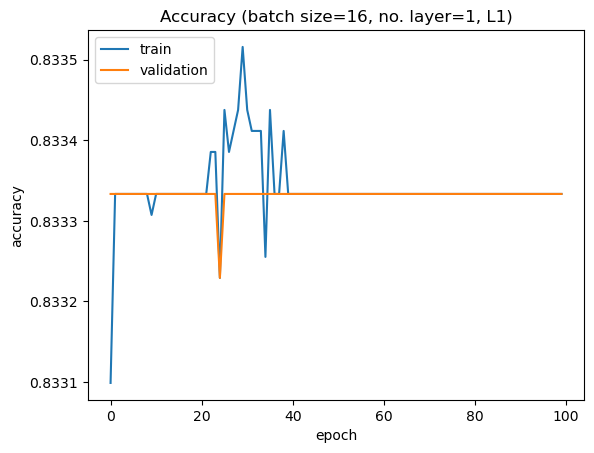

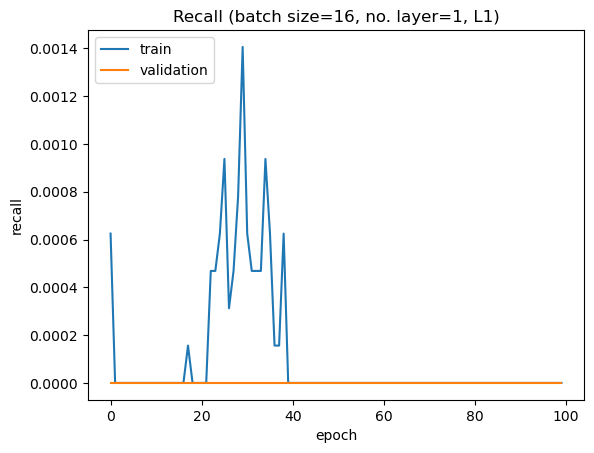

In [37]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [38]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.167
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.167
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 32, number of layer = 1

In [39]:
batch_size = 32
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
1200/1200 - 4s - loss: 0.1667 - accuracy: 0.8329 - recall_7: 0.0027 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_7: 0.0000e+00
Epoch 2/100
1200/1200 - 4s - loss: 0.1666 - accuracy: 0.8332 - recall_7: 9.3750e-04 - val_loss: 0.1668 - val_accuracy: 0.8329 - val_recall_7: 6.2500e-04
Epoch 3/100
1200/1200 - 3s - loss: 0.1663 - accuracy: 0.8335 - recall_7: 0.0031 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_7: 0.0000e+00
Epoch 4/100
1200/1200 - 3s - loss: 0.1661 - accuracy: 0.8338 - recall_7: 0.0044 - val_loss: 0.1671 - val_accuracy: 0.8326 - val_recall_7: 0.0025
Epoch 5/100
1200/1200 - 3s - loss: 0.1658 - accuracy: 0.8339 - recall_7: 0.0077 - val_loss: 0.1672 - val_accuracy: 0.8327 - val_recall_7: 0.0000e+00
Epoch 6/100
1200/1200 - 3s - loss: 0.1647 - accuracy: 0.8351 - recall_7: 0.0136 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_7: 0.0000e+00
Epoch 7/100
1200/1200 - 3s - loss: 0.1646 - accuracy: 0.8353 - recall_7: 0.0148 - val_loss: 0.1668 - val_a

Epoch 56/100
1200/1200 - 4s - loss: 0.1620 - accuracy: 0.8380 - recall_7: 0.0286 - val_loss: 0.1669 - val_accuracy: 0.8331 - val_recall_7: 0.0000e+00
Epoch 57/100
1200/1200 - 4s - loss: 0.1620 - accuracy: 0.8380 - recall_7: 0.0284 - val_loss: 0.1670 - val_accuracy: 0.8330 - val_recall_7: 0.0000e+00
Epoch 58/100
1200/1200 - 4s - loss: 0.1620 - accuracy: 0.8380 - recall_7: 0.0281 - val_loss: 0.1671 - val_accuracy: 0.8329 - val_recall_7: 0.0000e+00
Epoch 59/100
1200/1200 - 4s - loss: 0.1619 - accuracy: 0.8380 - recall_7: 0.0288 - val_loss: 0.1669 - val_accuracy: 0.8331 - val_recall_7: 0.0000e+00
Epoch 60/100
1200/1200 - 4s - loss: 0.1618 - accuracy: 0.8382 - recall_7: 0.0292 - val_loss: 0.1669 - val_accuracy: 0.8331 - val_recall_7: 0.0000e+00
Epoch 61/100
1200/1200 - 4s - loss: 0.1619 - accuracy: 0.8381 - recall_7: 0.0289 - val_loss: 0.1669 - val_accuracy: 0.8331 - val_recall_7: 0.0000e+00
Epoch 62/100
1200/1200 - 4s - loss: 0.1618 - accuracy: 0.8382 - recall_7: 0.0289 - val_loss: 0.1669 

#### Predict

In [40]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

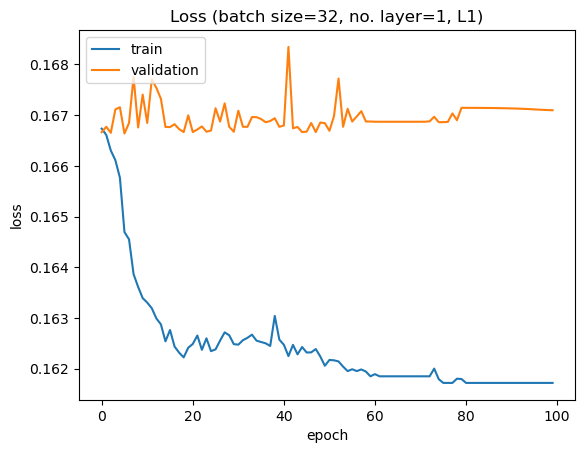

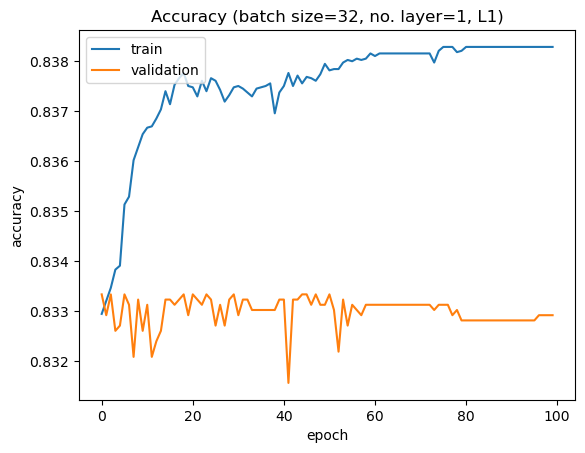

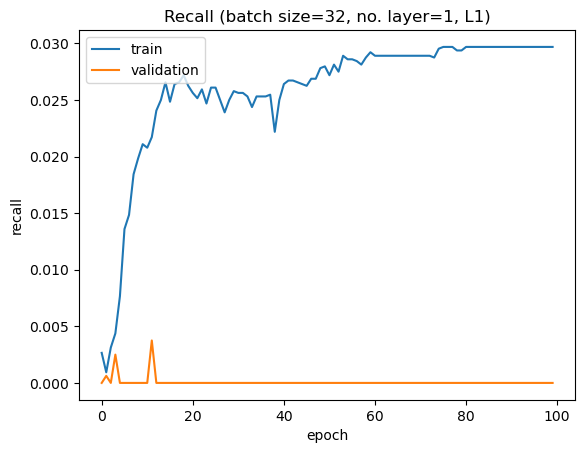

In [41]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [42]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.162
Training Accuracy: 0.838
Training Recall: 0.03


Validation Loss: 0.167
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 64, number of layer = 1

In [43]:
batch_size = 64
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.1673 - accuracy: 0.8322 - recall_8: 0.0036 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_8: 0.0000e+00
Epoch 2/100
600/600 - 2s - loss: 0.1657 - accuracy: 0.8338 - recall_8: 0.0070 - val_loss: 0.1678 - val_accuracy: 0.8318 - val_recall_8: 0.0031
Epoch 3/100
600/600 - 2s - loss: 0.1643 - accuracy: 0.8353 - recall_8: 0.0156 - val_loss: 0.1666 - val_accuracy: 0.8326 - val_recall_8: 6.2500e-04
Epoch 4/100
600/600 - 2s - loss: 0.1633 - accuracy: 0.8364 - recall_8: 0.0225 - val_loss: 0.1669 - val_accuracy: 0.8329 - val_recall_8: 0.0000e+00
Epoch 5/100
600/600 - 2s - loss: 0.1629 - accuracy: 0.8367 - recall_8: 0.0252 - val_loss: 0.1668 - val_accuracy: 0.8330 - val_recall_8: 0.0000e+00
Epoch 6/100
600/600 - 2s - loss: 0.1615 - accuracy: 0.8383 - recall_8: 0.0322 - val_loss: 0.1671 - val_accuracy: 0.8326 - val_recall_8: 0.0000e+00
Epoch 7/100
600/600 - 2s - loss: 0.1616 - accuracy: 0.8381 - recall_8: 0.0317 - val_loss: 0.1668 - val_accuracy: 0.8331 - 

Epoch 57/100
600/600 - 2s - loss: 0.1572 - accuracy: 0.8428 - recall_8: 0.0572 - val_loss: 0.1677 - val_accuracy: 0.8323 - val_recall_8: 0.0012
Epoch 58/100
600/600 - 2s - loss: 0.1573 - accuracy: 0.8426 - recall_8: 0.0564 - val_loss: 0.1670 - val_accuracy: 0.8330 - val_recall_8: 0.0000e+00
Epoch 59/100
600/600 - 2s - loss: 0.1574 - accuracy: 0.8426 - recall_8: 0.0569 - val_loss: 0.1673 - val_accuracy: 0.8326 - val_recall_8: 0.0000e+00
Epoch 60/100
600/600 - 2s - loss: 0.1574 - accuracy: 0.8426 - recall_8: 0.0564 - val_loss: 0.1676 - val_accuracy: 0.8324 - val_recall_8: 0.0000e+00
Epoch 61/100
600/600 - 2s - loss: 0.1571 - accuracy: 0.8429 - recall_8: 0.0580 - val_loss: 0.1669 - val_accuracy: 0.8331 - val_recall_8: 0.0000e+00
Epoch 62/100
600/600 - 2s - loss: 0.1572 - accuracy: 0.8428 - recall_8: 0.0578 - val_loss: 0.1670 - val_accuracy: 0.8329 - val_recall_8: 0.0000e+00
Epoch 63/100
600/600 - 2s - loss: 0.1569 - accuracy: 0.8431 - recall_8: 0.0587 - val_loss: 0.1671 - val_accuracy: 0.

#### Predict

In [44]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

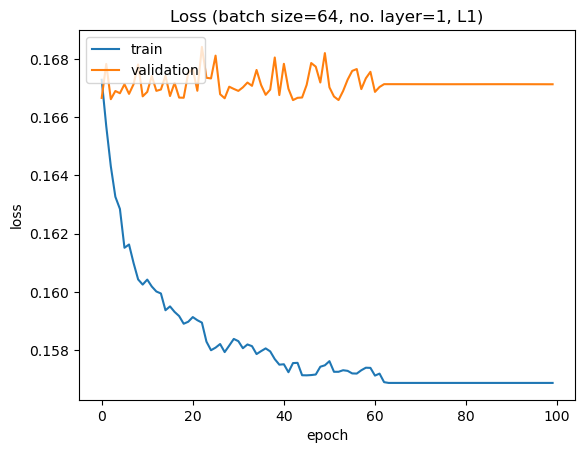

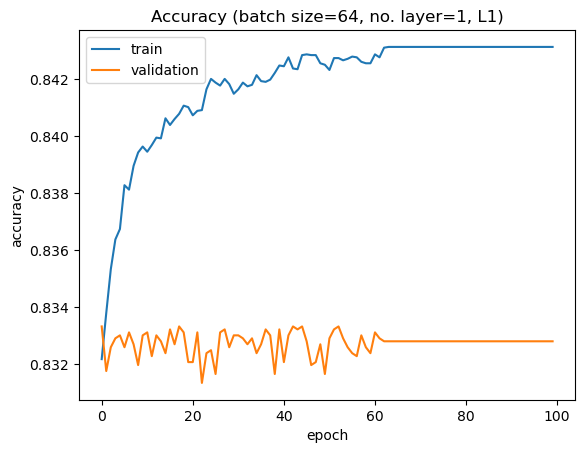

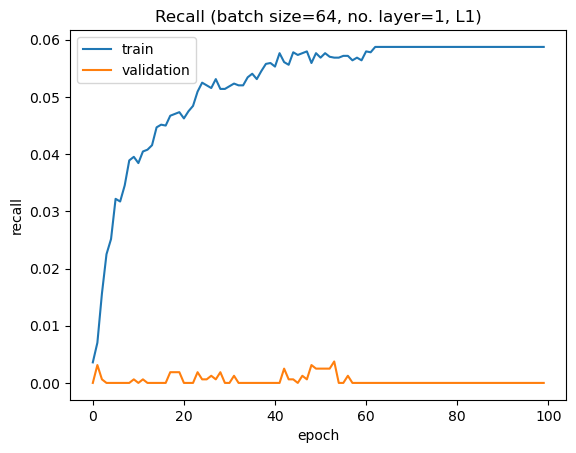

In [45]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [46]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.157
Training Accuracy: 0.843
Training Recall: 0.059


Validation Loss: 0.167
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 16, number of layer = 2

In [47]:
def create_shared_network(input_shape):
    model = keras.Sequential([
        
    keras.Input(shape=input_shape),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L1_augmented\\resnet_{}_2_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L1_augmented\\resnet_{}_2_{}.png".format(batch_size, metric))
    plt.show()

In [48]:
batch_size = 16
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
2400/2400 - 6s - loss: 0.1669 - accuracy: 0.8330 - recall_9: 0.0014 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00
Epoch 2/100
2400/2400 - 5s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00
Epoch 3/100
2400/2400 - 5s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00
Epoch 4/100
2400/2400 - 5s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00
Epoch 5/100
2400/2400 - 5s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00
Epoch 6/100
2400/2400 - 5s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00
Epoch 7/100
2400/2400 - 5s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - 

Epoch 55/100
2400/2400 - 4s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00
Epoch 56/100
2400/2400 - 4s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00
Epoch 57/100
2400/2400 - 4s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00
Epoch 58/100
2400/2400 - 4s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00
Epoch 59/100
2400/2400 - 4s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00
Epoch 60/100
2400/2400 - 4s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00
Epoch 61/100
2400/2400 - 4s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.

#### Predict

In [49]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

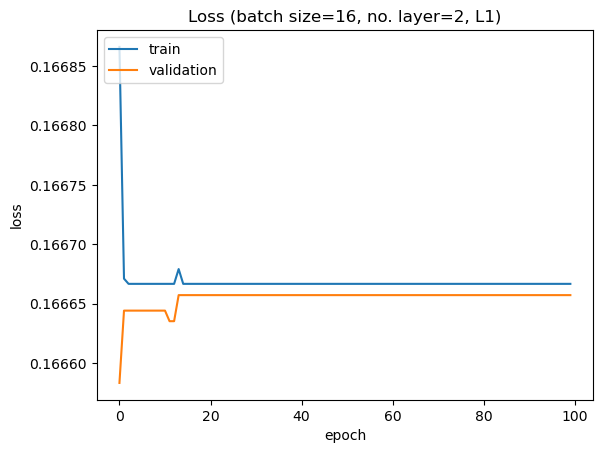

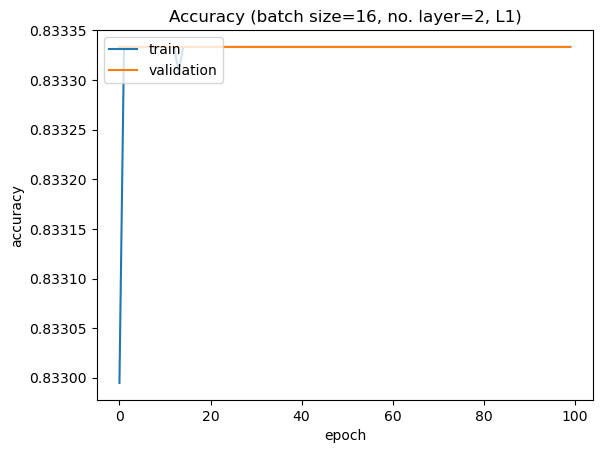

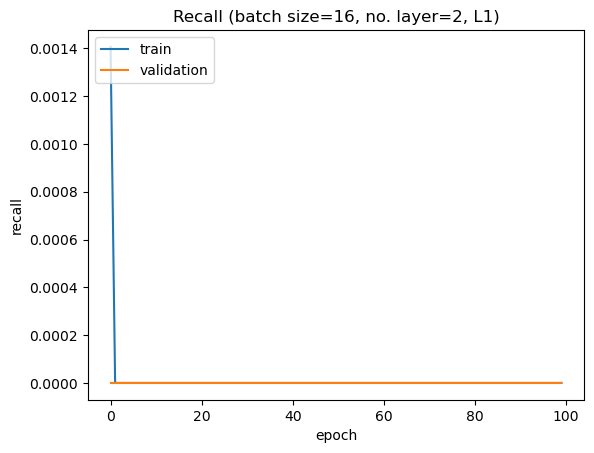

In [50]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [51]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.167
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.167
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 32, number of layer = 2

In [52]:
batch_size = 32
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
1200/1200 - 3s - loss: 0.1670 - accuracy: 0.8327 - recall_10: 4.6875e-04 - val_loss: 0.1664 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00
Epoch 2/100
1200/1200 - 3s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00
Epoch 3/100
1200/1200 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00
Epoch 4/100
1200/1200 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00
Epoch 5/100
1200/1200 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00
Epoch 6/100
1200/1200 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00
Epoch 7/100
1200/1200 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_

Epoch 54/100
1200/1200 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00
Epoch 55/100
1200/1200 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00
Epoch 56/100
1200/1200 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00
Epoch 57/100
1200/1200 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00
Epoch 58/100
1200/1200 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00
Epoch 59/100
1200/1200 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00
Epoch 60/100
1200/1200 - 2s - loss: 0.1667 - accuracy: 0.8333 - 

#### Predict

In [53]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

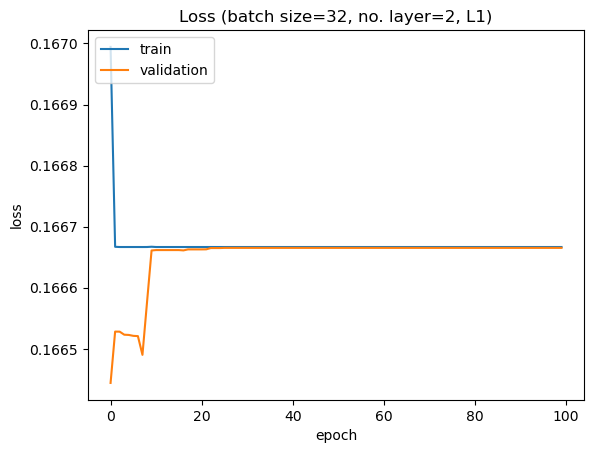

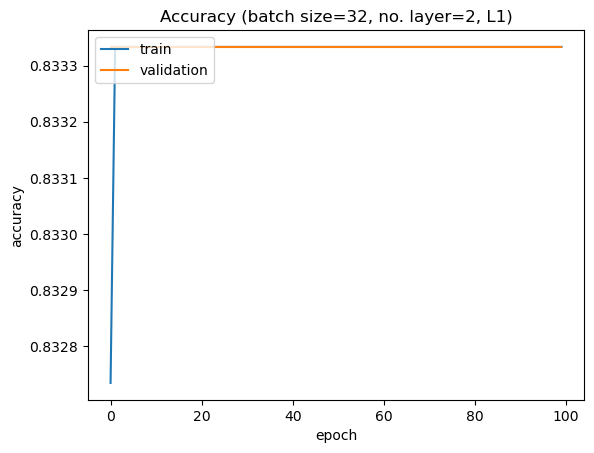

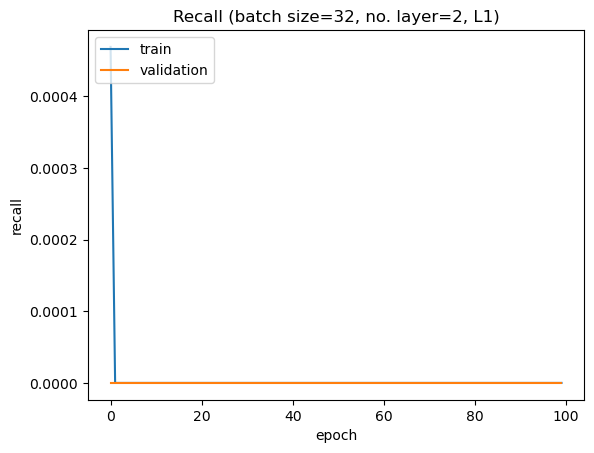

In [54]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [55]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.167
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.167
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 64, number of layer = 2

In [56]:
batch_size = 64
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.1667 - accuracy: 0.8332 - recall_11: 3.1250e-04 - val_loss: 0.1658 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00
Epoch 2/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1657 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00
Epoch 3/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00
Epoch 4/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00
Epoch 5/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00
Epoch 6/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00
Epoch 7/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00

Epoch 55/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00
Epoch 56/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00
Epoch 57/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00
Epoch 58/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00
Epoch 59/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00
Epoch 60/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00
Epoch 61/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0

#### Predict

In [57]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

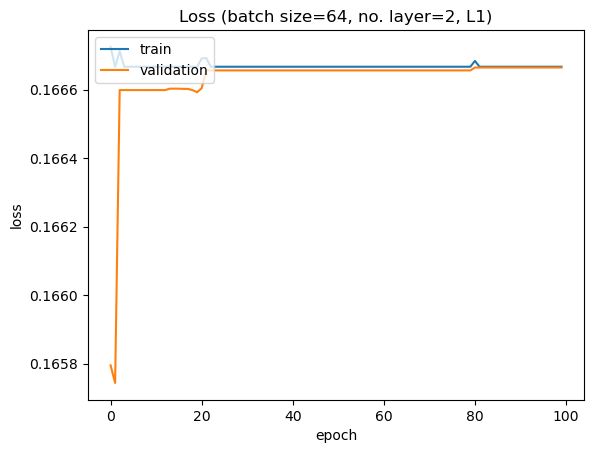

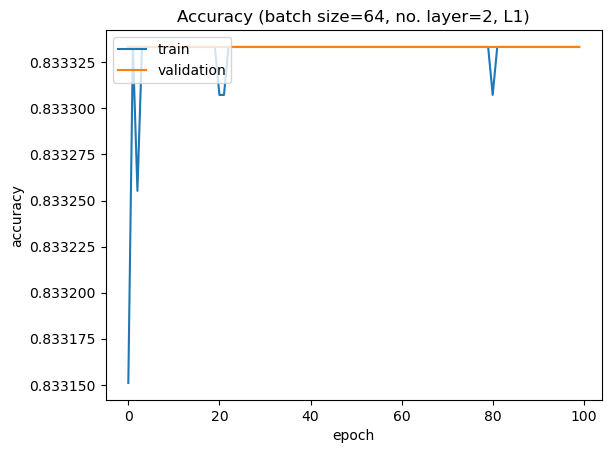

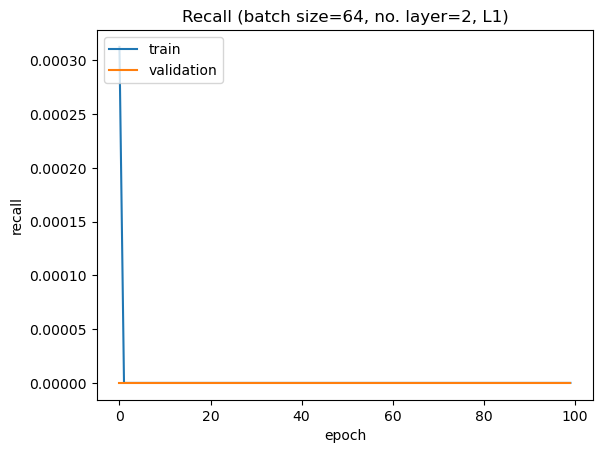

In [58]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [59]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.167
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.167
Validation Accuracy: 0.833
Validation Recall: 0.0


## densenet

In [60]:
# left_train = np.load('vgg_train_left.npy')
# left_train_augmented = np.load('AUG_vgg_train_left.npy')
# left_train = np.concatenate((left_train, left_train_augmented))
# right_train = np.load('vgg_train_right.npy')
# left_test = np.load('vgg_test_left.npy')
# right_test = np.load('vgg_test_right.npy')

# left_train = np.load('resnet_train_left.npy')
# left_train_augmented = np.load('AUG_resnet_train_left.npy')
# left_train = np.concatenate((left_train, left_train_augmented))
# right_train = np.load('resnet_train_right.npy')
# left_test = np.load('resnet_test_left.npy')
# right_test = np.load('resnet_test_right.npy')

left_train = np.load('densenet_train_left.npy')
left_train_augmented = np.load('AUG_densenet_train_left.npy')
left_train = np.concatenate((left_train, left_train_augmented))
right_train = np.load('densenet_train_right.npy')
left_test = np.load('densenet_test_left.npy')
right_test = np.load('densenet_test_right.npy')

In [61]:
left_array_dict = {}
right_array_dict = {}
for i in range(len(ground_truth)):
    left_array_dict[ground_truth['left'][i]] = left_train[i]
    if i%4 == 0:
        right_array_dict[ground_truth['right'][i//4]] = right_train[i//4]

pairs_for_training = []
for i in range(len(paired_data)):
    pairs_for_training.append([left_array_dict.get(paired_data[i][0]) , right_array_dict.get(paired_data[i][1])])
    
pairs_for_training = np.array(pairs_for_training)

left_images = pairs_for_training[:, 0]
right_images = pairs_for_training[:, 1]



test_candidates = pd.read_csv('.\COMP90086_2023_TLLdataset\\test_candidates.csv')

path = ".\COMP90086_2023_TLLdataset\\test\\left"
dir_list = os.listdir(path)
test_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\test\\right"
dir_list = os.listdir(path)
test_right_images_list = dir_list

left_array_dict = {}
for i in range(len(test_left_images_list)):
    left_array_dict[test_left_images_list[i][:3]] = left_test[i]
    
right_array_dict = {}
for i in range(len(test_right_images_list)):
    right_array_dict[test_right_images_list[i][:3]] = right_test[i]
    
pairs_for_test = []
for j in range(len(test_candidates)):
    for i in range(20):
        pairs_for_test.append([left_array_dict.get(test_candidates.iloc[j][0]) , right_array_dict.get(test_candidates.iloc[j][i+1])])

pairs_for_test = np.array(pairs_for_test)

x_test_1 = pairs_for_test[:, 0]
x_test_2 = pairs_for_test[:, 1]

### batch size = 16, number of layer = 1

In [62]:
# input_shape = (512,)
# input_shape = (2048,)
input_shape = (1024,)

def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(64, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L1_augmented\\densenet_{}_1_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L1_augmented\\densenet_{}_1_{}.png".format(batch_size, metric))
    plt.show()

In [63]:
batch_size = 16
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
2400/2400 - 3s - loss: 0.1668 - accuracy: 0.8330 - recall_12: 6.2500e-04 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_12: 0.0000e+00
Epoch 2/100
2400/2400 - 2s - loss: 0.1666 - accuracy: 0.8333 - recall_12: 1.5625e-04 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_12: 0.0000e+00
Epoch 3/100
2400/2400 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_12: 1.5625e-04 - val_loss: 0.1667 - val_accuracy: 0.8332 - val_recall_12: 0.0000e+00
Epoch 4/100
2400/2400 - 2s - loss: 0.1666 - accuracy: 0.8334 - recall_12: 0.0011 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_12: 0.0000e+00
Epoch 5/100
2400/2400 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_12: 1.5625e-04 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_12: 0.0000e+00
Epoch 6/100
2400/2400 - 2s - loss: 0.1666 - accuracy: 0.8334 - recall_12: 6.2500e-04 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_12: 0.0000e+00
Epoch 7/100
2400/2400 - 2s - loss: 0.1666 - accuracy: 0.8334 - recall_12: 

Epoch 54/100
2400/2400 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_12: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_12: 0.0000e+00
Epoch 55/100
2400/2400 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_12: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_12: 0.0000e+00
Epoch 56/100
2400/2400 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_12: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_12: 0.0000e+00
Epoch 57/100
2400/2400 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_12: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_12: 0.0000e+00
Epoch 58/100
2400/2400 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_12: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_12: 0.0000e+00
Epoch 59/100
2400/2400 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_12: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_12: 0.0000e+00
Epoch 60/100
2400/2400 - 2s - loss: 0.1667 - accuracy: 0.8333 - 

#### Predict

In [64]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

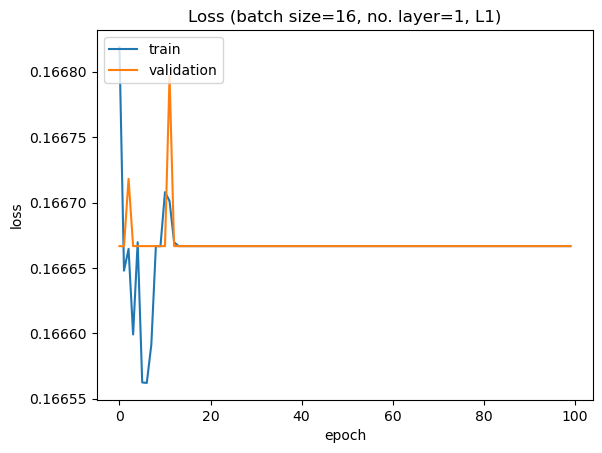

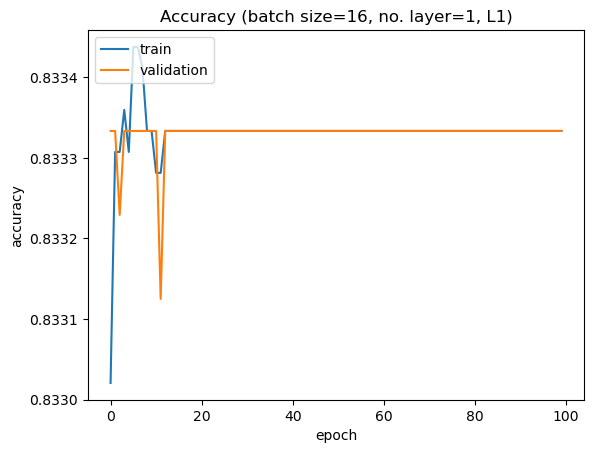

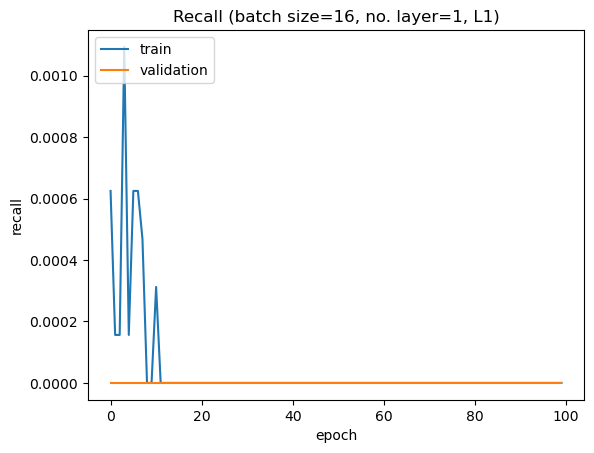

In [65]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [66]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.167
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.167
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 32, number of layer = 1

In [67]:
batch_size = 32
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
1200/1200 - 1s - loss: 0.1669 - accuracy: 0.8329 - recall_13: 3.1250e-04 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_13: 0.0000e+00
Epoch 2/100
1200/1200 - 1s - loss: 0.1665 - accuracy: 0.8332 - recall_13: 0.0023 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_13: 0.0000e+00
Epoch 3/100
1200/1200 - 1s - loss: 0.1648 - accuracy: 0.8346 - recall_13: 0.0117 - val_loss: 0.1663 - val_accuracy: 0.8334 - val_recall_13: 0.0019
Epoch 4/100
1200/1200 - 1s - loss: 0.1625 - accuracy: 0.8371 - recall_13: 0.0256 - val_loss: 0.1667 - val_accuracy: 0.8332 - val_recall_13: 0.0000e+00
Epoch 5/100
1200/1200 - 1s - loss: 0.1609 - accuracy: 0.8388 - recall_13: 0.0373 - val_loss: 0.1676 - val_accuracy: 0.8320 - val_recall_13: 0.0000e+00
Epoch 6/100
1200/1200 - 1s - loss: 0.1595 - accuracy: 0.8404 - recall_13: 0.0445 - val_loss: 0.1674 - val_accuracy: 0.8325 - val_recall_13: 0.0000e+00
Epoch 7/100
1200/1200 - 1s - loss: 0.1582 - accuracy: 0.8413 - recall_13: 0.0517 - val_loss: 0

1200/1200 - 1s - loss: 0.1531 - accuracy: 0.8469 - recall_13: 0.0812 - val_loss: 0.1676 - val_accuracy: 0.8323 - val_recall_13: 0.0000e+00
Epoch 56/100
1200/1200 - 1s - loss: 0.1531 - accuracy: 0.8469 - recall_13: 0.0812 - val_loss: 0.1676 - val_accuracy: 0.8323 - val_recall_13: 0.0000e+00
Epoch 57/100
1200/1200 - 1s - loss: 0.1531 - accuracy: 0.8469 - recall_13: 0.0812 - val_loss: 0.1676 - val_accuracy: 0.8323 - val_recall_13: 0.0000e+00
Epoch 58/100
1200/1200 - 1s - loss: 0.1531 - accuracy: 0.8469 - recall_13: 0.0812 - val_loss: 0.1676 - val_accuracy: 0.8322 - val_recall_13: 0.0000e+00
Epoch 59/100
1200/1200 - 1s - loss: 0.1531 - accuracy: 0.8469 - recall_13: 0.0812 - val_loss: 0.1676 - val_accuracy: 0.8322 - val_recall_13: 0.0000e+00
Epoch 60/100
1200/1200 - 1s - loss: 0.1531 - accuracy: 0.8469 - recall_13: 0.0812 - val_loss: 0.1677 - val_accuracy: 0.8322 - val_recall_13: 0.0000e+00
Epoch 61/100
1200/1200 - 1s - loss: 0.1531 - accuracy: 0.8469 - recall_13: 0.0812 - val_loss: 0.1678 

#### Predict

In [68]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

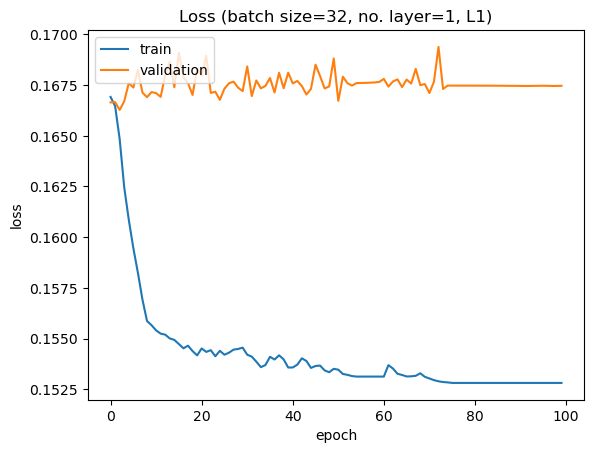

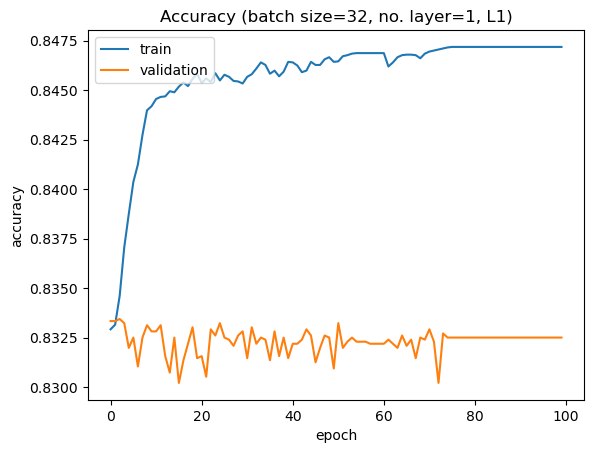

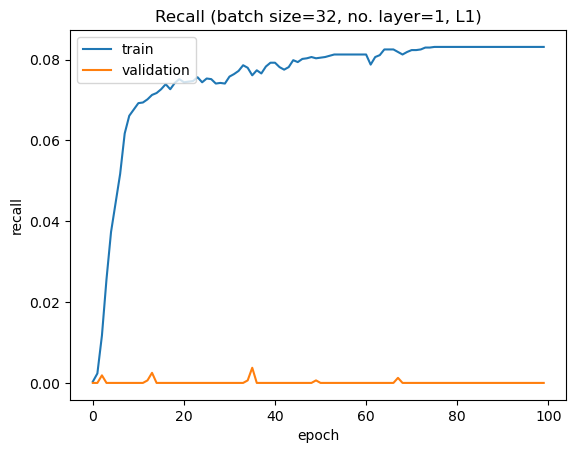

In [69]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [70]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.153
Training Accuracy: 0.847
Training Recall: 0.083


Validation Loss: 0.167
Validation Accuracy: 0.832
Validation Recall: 0.0


### batch size = 64, number of layer = 1

In [71]:
batch_size = 64
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 1s - loss: 0.1671 - accuracy: 0.8326 - recall_14: 0.0014 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_14: 0.0000e+00
Epoch 2/100
600/600 - 1s - loss: 0.1666 - accuracy: 0.8333 - recall_14: 1.5625e-04 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_14: 0.0000e+00
Epoch 3/100
600/600 - 1s - loss: 0.1665 - accuracy: 0.8333 - recall_14: 0.0014 - val_loss: 0.1665 - val_accuracy: 0.8332 - val_recall_14: 0.0000e+00
Epoch 4/100
600/600 - 1s - loss: 0.1657 - accuracy: 0.8339 - recall_14: 0.0063 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_14: 0.0000e+00
Epoch 5/100
600/600 - 1s - loss: 0.1629 - accuracy: 0.8362 - recall_14: 0.0245 - val_loss: 0.1673 - val_accuracy: 0.8324 - val_recall_14: 0.0000e+00
Epoch 6/100
600/600 - 1s - loss: 0.1594 - accuracy: 0.8399 - recall_14: 0.0459 - val_loss: 0.1669 - val_accuracy: 0.8331 - val_recall_14: 0.0000e+00
Epoch 7/100
600/600 - 1s - loss: 0.1569 - accuracy: 0.8426 - recall_14: 0.0628 - val_loss: 0.1670 - va

Epoch 57/100
600/600 - 1s - loss: 0.1403 - accuracy: 0.8596 - recall_14: 0.1591 - val_loss: 0.1687 - val_accuracy: 0.8308 - val_recall_14: 6.2500e-04
Epoch 58/100
600/600 - 1s - loss: 0.1405 - accuracy: 0.8594 - recall_14: 0.1580 - val_loss: 0.1696 - val_accuracy: 0.8297 - val_recall_14: 0.0000e+00
Epoch 59/100
600/600 - 1s - loss: 0.1402 - accuracy: 0.8597 - recall_14: 0.1591 - val_loss: 0.1691 - val_accuracy: 0.8306 - val_recall_14: 0.0031
Epoch 60/100
600/600 - 1s - loss: 0.1403 - accuracy: 0.8596 - recall_14: 0.1587 - val_loss: 0.1677 - val_accuracy: 0.8322 - val_recall_14: 0.0000e+00
Epoch 61/100
600/600 - 1s - loss: 0.1402 - accuracy: 0.8597 - recall_14: 0.1592 - val_loss: 0.1679 - val_accuracy: 0.8320 - val_recall_14: 0.0000e+00
Epoch 62/100
600/600 - 1s - loss: 0.1403 - accuracy: 0.8596 - recall_14: 0.1587 - val_loss: 0.1679 - val_accuracy: 0.8319 - val_recall_14: 6.2500e-04
Epoch 63/100
600/600 - 1s - loss: 0.1402 - accuracy: 0.8597 - recall_14: 0.1591 - val_loss: 0.1694 - val

#### Predict

In [72]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

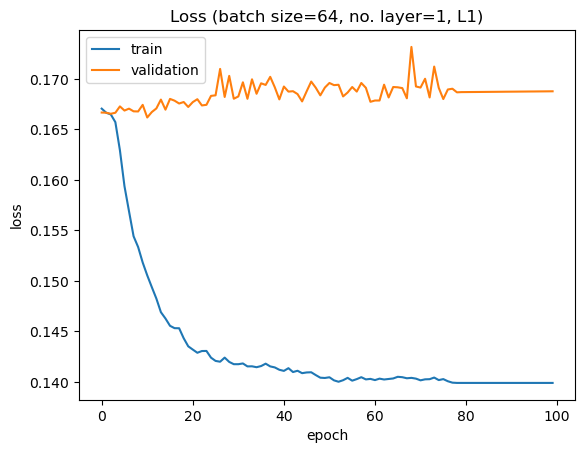

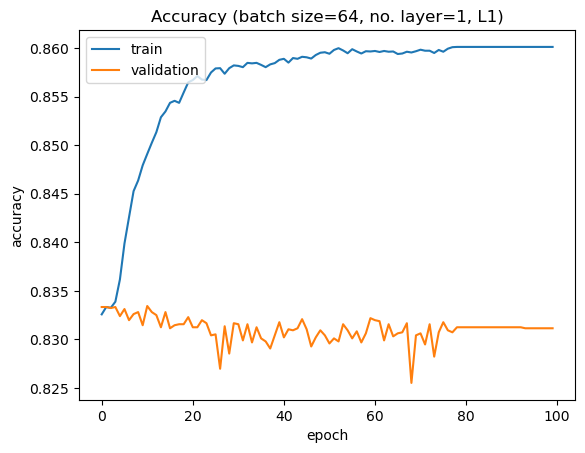

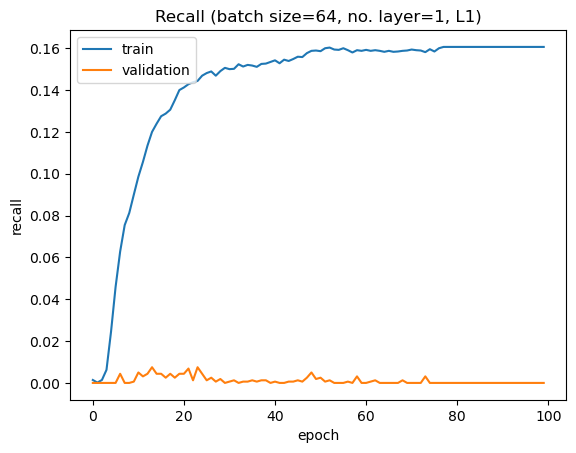

In [73]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [74]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.14
Training Accuracy: 0.86
Training Recall: 0.161


Validation Loss: 0.169
Validation Accuracy: 0.831
Validation Recall: 0.0


### batch size = 16, number of layer = 2

In [75]:
def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L1_augmented\\densenet_{}_2_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L1_augmented\\densenet_{}_2_{}.png".format(batch_size, metric))
    plt.show()

In [76]:
batch_size = 16
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
2400/2400 - 3s - loss: 0.1668 - accuracy: 0.8331 - recall_15: 6.2500e-04 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00
Epoch 2/100
2400/2400 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00
Epoch 3/100
2400/2400 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00
Epoch 4/100
2400/2400 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00
Epoch 5/100
2400/2400 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00
Epoch 6/100
2400/2400 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00
Epoch 7/100
2400/2400 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_

Epoch 54/100
2400/2400 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00
Epoch 55/100
2400/2400 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00
Epoch 56/100
2400/2400 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00
Epoch 57/100
2400/2400 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00
Epoch 58/100
2400/2400 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00
Epoch 59/100
2400/2400 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00
Epoch 60/100
2400/2400 - 2s - loss: 0.1667 - accuracy: 0.8333 - 

#### Predict

In [77]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

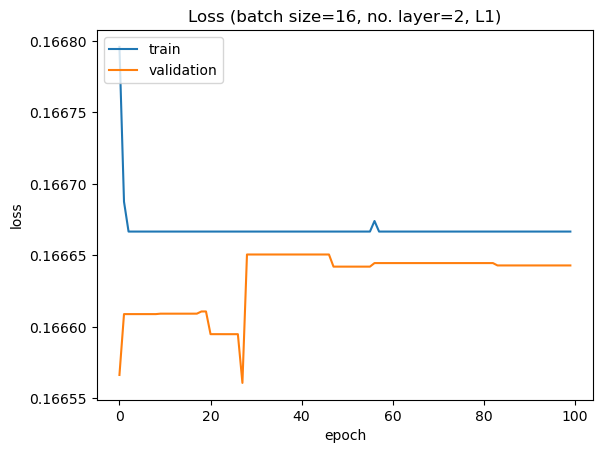

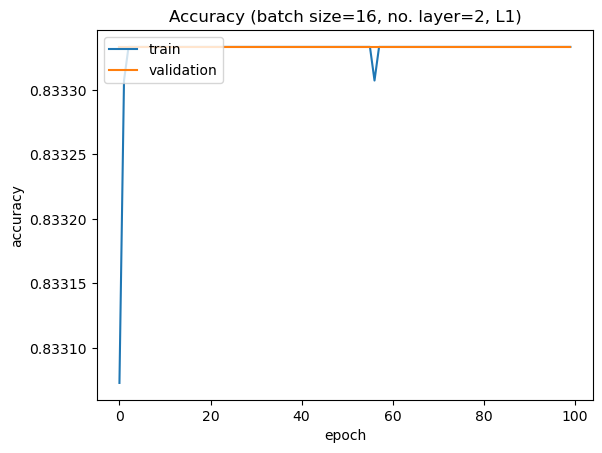

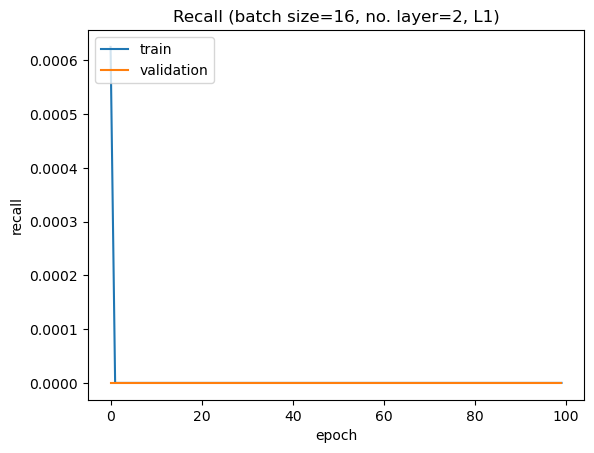

In [78]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [79]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.167
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.167
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 32, number of layer = 2

In [80]:
batch_size = 32
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
1200/1200 - 2s - loss: 0.1668 - accuracy: 0.8330 - recall_16: 0.0011 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00
Epoch 2/100
1200/1200 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00
Epoch 3/100
1200/1200 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00
Epoch 4/100
1200/1200 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00
Epoch 5/100
1200/1200 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00
Epoch 6/100
1200/1200 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00
Epoch 7/100
1200/1200 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 

Epoch 54/100
1200/1200 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00
Epoch 55/100
1200/1200 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00
Epoch 56/100
1200/1200 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00
Epoch 57/100
1200/1200 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00
Epoch 58/100
1200/1200 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00
Epoch 59/100
1200/1200 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00
Epoch 60/100
1200/1200 - 1s - loss: 0.1667 - accuracy: 0.8333 - 

#### Predict

In [81]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

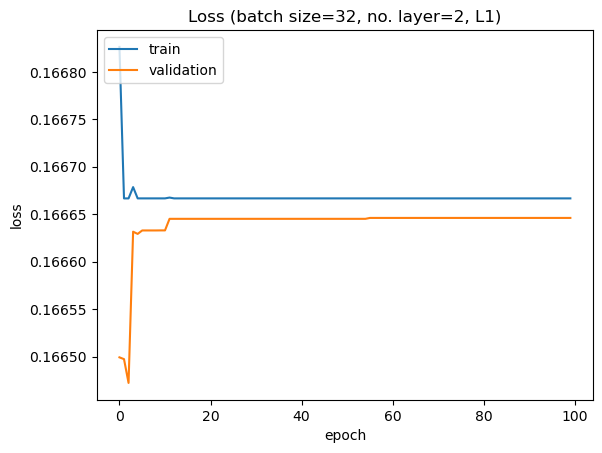

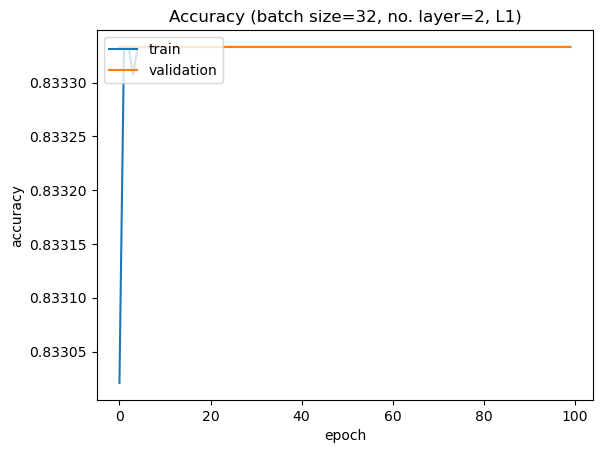

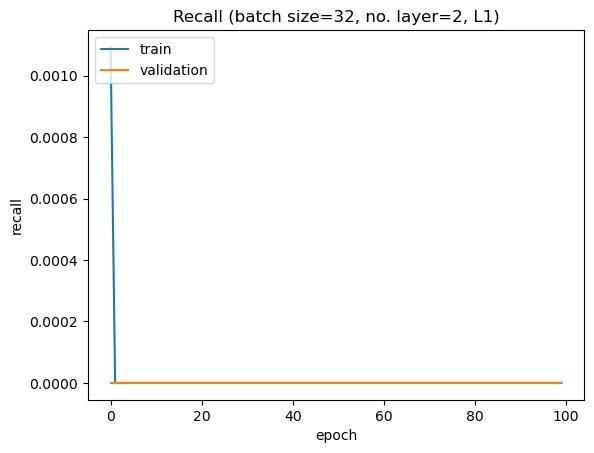

In [82]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [83]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.167
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.167
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 64, number of layer = 2

In [84]:
batch_size = 64
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 1s - loss: 0.1676 - accuracy: 0.8318 - recall_17: 0.0039 - val_loss: 0.1661 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00
Epoch 2/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1658 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00
Epoch 3/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1664 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00
Epoch 4/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1664 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00
Epoch 5/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1664 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00
Epoch 6/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00
Epoch 7/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - v

Epoch 55/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00
Epoch 56/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00
Epoch 57/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00
Epoch 58/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00
Epoch 59/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00
Epoch 60/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00
Epoch 61/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0

#### Predict

In [85]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

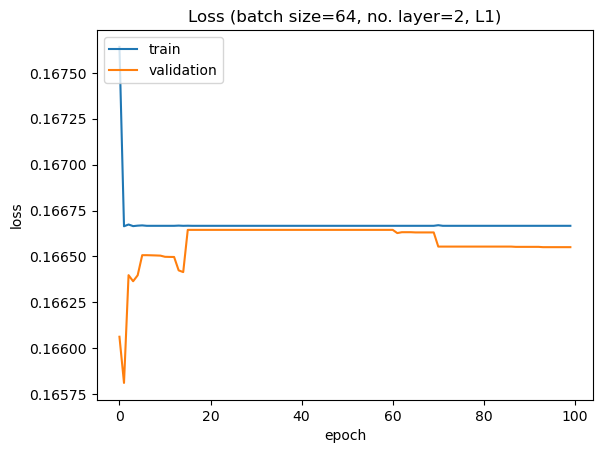

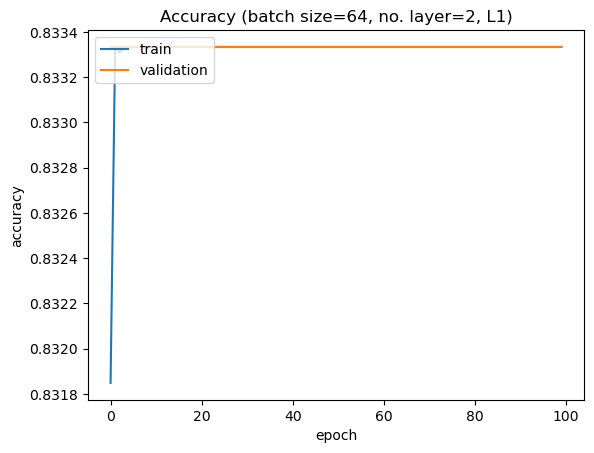

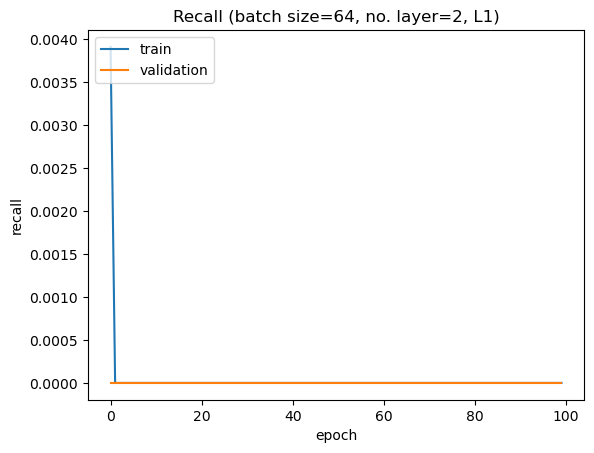

In [86]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [87]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.167
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.167
Validation Accuracy: 0.833
Validation Recall: 0.0


# L2 Distance

## vgg

In [88]:
left_train = np.load('vgg_train_left.npy')
left_train_augmented = np.load('AUG_vgg_train_left.npy')
left_train = np.concatenate((left_train, left_train_augmented))
right_train = np.load('vgg_train_right.npy')
left_test = np.load('vgg_test_left.npy')
right_test = np.load('vgg_test_right.npy')

# left_train = np.load('resnet_train_left.npy')
# left_train_augmented = np.load('AUG_resnet_train_left.npy')
# left_train = np.concatenate((left_train, left_train_augmented))
# right_train = np.load('resnet_train_right.npy')
# left_test = np.load('resnet_test_left.npy')
# right_test = np.load('resnet_test_right.npy')

# left_train = np.load('densenet_train_left.npy')
# left_train_augmented = np.load('AUG_densenet_train_left.npy')
# left_train = np.concatenate((left_train, left_train_augmented))
# right_train = np.load('densenet_train_right.npy')
# left_test = np.load('densenet_test_left.npy')
# right_test = np.load('densenet_test_right.npy')

In [89]:
left_array_dict = {}
right_array_dict = {}
for i in range(len(ground_truth)):
    left_array_dict[ground_truth['left'][i]] = left_train[i]
    if i%4 == 0:
        right_array_dict[ground_truth['right'][i//4]] = right_train[i//4]

pairs_for_training = []
for i in range(len(paired_data)):
    pairs_for_training.append([left_array_dict.get(paired_data[i][0]) , right_array_dict.get(paired_data[i][1])])
    
pairs_for_training = np.array(pairs_for_training)

left_images = pairs_for_training[:, 0]
right_images = pairs_for_training[:, 1]



test_candidates = pd.read_csv('.\COMP90086_2023_TLLdataset\\test_candidates.csv')

path = ".\COMP90086_2023_TLLdataset\\test\\left"
dir_list = os.listdir(path)
test_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\test\\right"
dir_list = os.listdir(path)
test_right_images_list = dir_list

left_array_dict = {}
for i in range(len(test_left_images_list)):
    left_array_dict[test_left_images_list[i][:3]] = left_test[i]
    
right_array_dict = {}
for i in range(len(test_right_images_list)):
    right_array_dict[test_right_images_list[i][:3]] = right_test[i]
    
pairs_for_test = []
for j in range(len(test_candidates)):
    for i in range(20):
        pairs_for_test.append([left_array_dict.get(test_candidates.iloc[j][0]) , right_array_dict.get(test_candidates.iloc[j][i+1])])

pairs_for_test = np.array(pairs_for_test)

x_test_1 = pairs_for_test[:, 0]
x_test_2 = pairs_for_test[:, 1]

### batch size = 16, number of layer = 1

In [90]:
input_shape = (512,)
# input_shape = (2048,)
# input_shape = (1024,)

def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(64, activation='relu')
        
    ])
    
    return model

# Reference:
# https://keras.io/examples/vision/siamese_contrastive/?fbclid=IwAR0d0p7eAw2zZDUiyaPhkt-ZQuDQ32U7rRIHxv4ErsSn9yVkBFbfzBC42fQ
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

def create_siamese_network(input_shape):
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    shared_network = create_shared_network(input_shape)
    left_features = shared_network(left_input)
    right_features = shared_network(right_input)

#     distance = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([left_features, right_features])
#     normal_layer = tf.keras.layers.BatchNormalization()(distance)
#     similarity_score = Dense(1, activation='sigmoid')(distance)
    
    distance = Lambda(euclidean_distance)([left_features, right_features])
    normal_layer = tf.keras.layers.BatchNormalization()(distance)
    similarity_score = layers.Dense(1, activation="sigmoid")(normal_layer)

    siamese_net = Model(inputs=[left_input, right_input], outputs=1-similarity_score)
    return siamese_net
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L2_augmented\\vgg_{}_1_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L2_augmented\\vgg_{}_1_{}.png".format(batch_size, metric))
    plt.show()

In [91]:
batch_size = 16
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
2400/2400 - 2s - loss: 0.1585 - accuracy: 0.8067 - recall_18: 0.0413 - val_loss: 0.1426 - val_accuracy: 0.8333 - val_recall_18: 0.0000e+00
Epoch 2/100
2400/2400 - 2s - loss: 0.1296 - accuracy: 0.8337 - recall_18: 0.0066 - val_loss: 0.1562 - val_accuracy: 0.8284 - val_recall_18: 0.0025
Epoch 3/100
2400/2400 - 2s - loss: 0.1178 - accuracy: 0.8439 - recall_18: 0.1394 - val_loss: 0.1650 - val_accuracy: 0.8157 - val_recall_18: 0.0225
Epoch 4/100
2400/2400 - 2s - loss: 0.1075 - accuracy: 0.8581 - recall_18: 0.2908 - val_loss: 0.1718 - val_accuracy: 0.8057 - val_recall_18: 0.0356
Epoch 5/100
2400/2400 - 2s - loss: 0.0994 - accuracy: 0.8703 - recall_18: 0.3959 - val_loss: 0.1707 - val_accuracy: 0.8107 - val_recall_18: 0.0300
Epoch 6/100
2400/2400 - 2s - loss: 0.0950 - accuracy: 0.8757 - recall_18: 0.4358 - val_loss: 0.1782 - val_accuracy: 0.7943 - val_recall_18: 0.0431
Epoch 7/100
2400/2400 - 2s - loss: 0.0908 - accuracy: 0.8808 - recall_18: 0.4764 - val_loss: 0.1848 - val_accuracy

Epoch 57/100
2400/2400 - 2s - loss: 0.0576 - accuracy: 0.9290 - recall_18: 0.7245 - val_loss: 0.1947 - val_accuracy: 0.7870 - val_recall_18: 0.0431
Epoch 58/100
2400/2400 - 2s - loss: 0.0573 - accuracy: 0.9285 - recall_18: 0.7202 - val_loss: 0.2017 - val_accuracy: 0.7761 - val_recall_18: 0.0469
Epoch 59/100
2400/2400 - 2s - loss: 0.0558 - accuracy: 0.9305 - recall_18: 0.7308 - val_loss: 0.1942 - val_accuracy: 0.7905 - val_recall_18: 0.0406
Epoch 60/100
2400/2400 - 2s - loss: 0.0549 - accuracy: 0.9318 - recall_18: 0.7356 - val_loss: 0.2003 - val_accuracy: 0.7792 - val_recall_18: 0.0506
Epoch 61/100
2400/2400 - 2s - loss: 0.0559 - accuracy: 0.9316 - recall_18: 0.7297 - val_loss: 0.1953 - val_accuracy: 0.7867 - val_recall_18: 0.0463
Epoch 62/100
2400/2400 - 2s - loss: 0.0557 - accuracy: 0.9308 - recall_18: 0.7252 - val_loss: 0.1954 - val_accuracy: 0.7864 - val_recall_18: 0.0500
Epoch 63/100
2400/2400 - 2s - loss: 0.0558 - accuracy: 0.9307 - recall_18: 0.7291 - val_loss: 0.1972 - val_accur

#### Predict

In [92]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

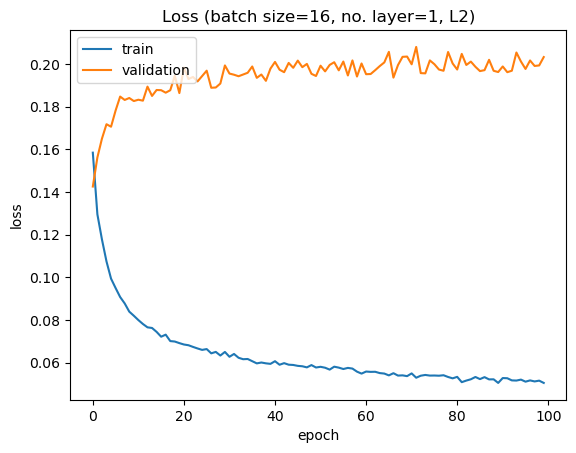

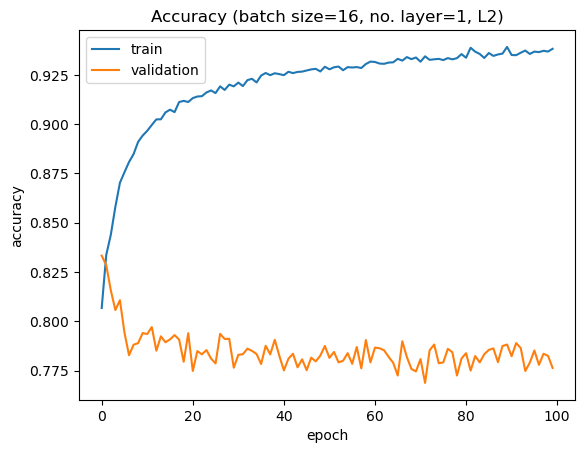

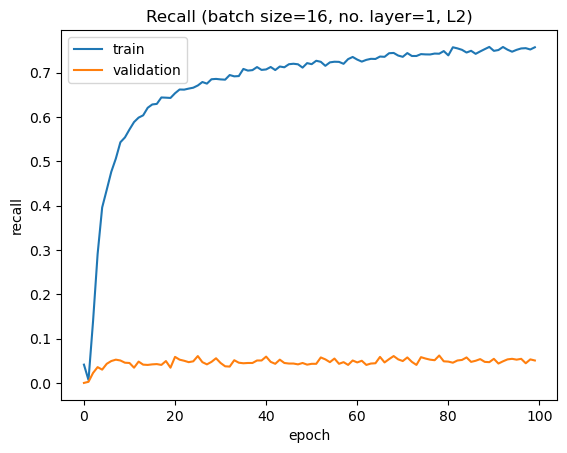

In [93]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [94]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.051
Training Accuracy: 0.938
Training Recall: 0.757


Validation Loss: 0.203
Validation Accuracy: 0.776
Validation Recall: 0.051


### batch size = 32, number of layer = 1

In [95]:
batch_size = 32
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
1200/1200 - 2s - loss: 0.1767 - accuracy: 0.7716 - recall_19: 0.1055 - val_loss: 0.1468 - val_accuracy: 0.8333 - val_recall_19: 0.0000e+00
Epoch 2/100
1200/1200 - 1s - loss: 0.1274 - accuracy: 0.8354 - recall_19: 0.0197 - val_loss: 0.1571 - val_accuracy: 0.8285 - val_recall_19: 0.0075
Epoch 3/100
1200/1200 - 1s - loss: 0.1089 - accuracy: 0.8582 - recall_19: 0.2416 - val_loss: 0.1732 - val_accuracy: 0.8015 - val_recall_19: 0.0181
Epoch 4/100
1200/1200 - 1s - loss: 0.0903 - accuracy: 0.8863 - recall_19: 0.4652 - val_loss: 0.1736 - val_accuracy: 0.8050 - val_recall_19: 0.0169
Epoch 5/100
1200/1200 - 1s - loss: 0.0765 - accuracy: 0.9042 - recall_19: 0.5855 - val_loss: 0.1857 - val_accuracy: 0.7855 - val_recall_19: 0.0288
Epoch 6/100
1200/1200 - 1s - loss: 0.0672 - accuracy: 0.9170 - recall_19: 0.6494 - val_loss: 0.1880 - val_accuracy: 0.7868 - val_recall_19: 0.0225
Epoch 7/100
1200/1200 - 1s - loss: 0.0607 - accuracy: 0.9246 - recall_19: 0.6947 - val_loss: 0.1853 - val_accuracy

Epoch 57/100
1200/1200 - 1s - loss: 0.0271 - accuracy: 0.9694 - recall_19: 0.8612 - val_loss: 0.2030 - val_accuracy: 0.7851 - val_recall_19: 0.0469
Epoch 58/100
1200/1200 - 1s - loss: 0.0275 - accuracy: 0.9688 - recall_19: 0.8608 - val_loss: 0.2014 - val_accuracy: 0.7877 - val_recall_19: 0.0425
Epoch 59/100
1200/1200 - 1s - loss: 0.0285 - accuracy: 0.9672 - recall_19: 0.8562 - val_loss: 0.2007 - val_accuracy: 0.7868 - val_recall_19: 0.0506
Epoch 60/100
1200/1200 - 1s - loss: 0.0272 - accuracy: 0.9688 - recall_19: 0.8647 - val_loss: 0.2008 - val_accuracy: 0.7879 - val_recall_19: 0.0469
Epoch 61/100
1200/1200 - 1s - loss: 0.0264 - accuracy: 0.9707 - recall_19: 0.8650 - val_loss: 0.2036 - val_accuracy: 0.7839 - val_recall_19: 0.0388
Epoch 62/100
1200/1200 - 1s - loss: 0.0270 - accuracy: 0.9695 - recall_19: 0.8622 - val_loss: 0.1997 - val_accuracy: 0.7901 - val_recall_19: 0.0388
Epoch 63/100
1200/1200 - 1s - loss: 0.0267 - accuracy: 0.9696 - recall_19: 0.8608 - val_loss: 0.2039 - val_accur

#### Predict

In [96]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

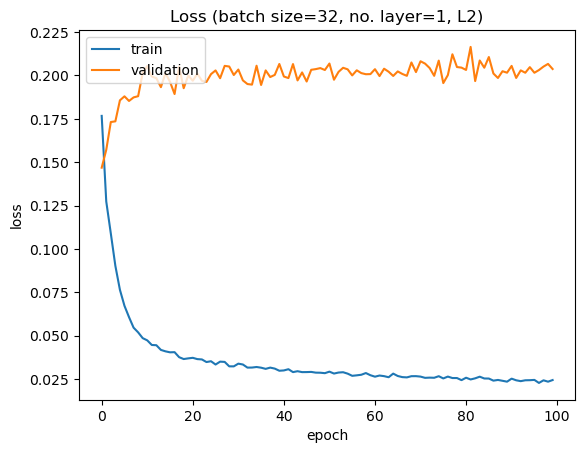

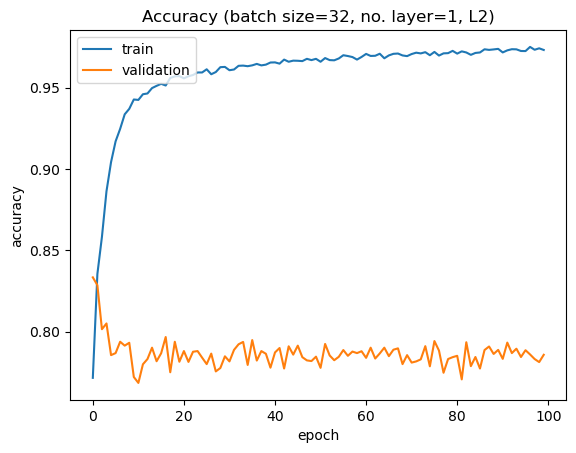

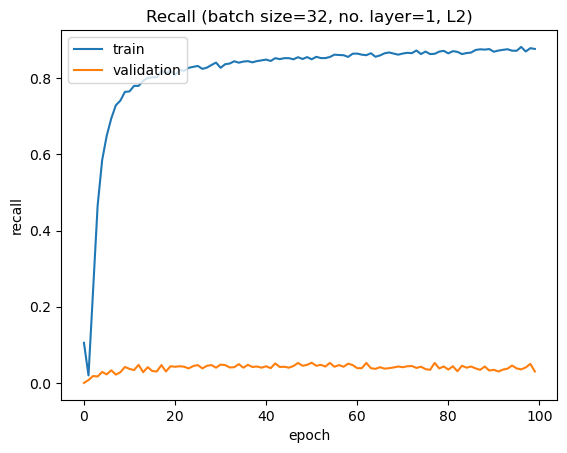

In [97]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [98]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.024
Training Accuracy: 0.973
Training Recall: 0.877


Validation Loss: 0.204
Validation Accuracy: 0.786
Validation Recall: 0.03


### batch size = 64, number of layer = 1

In [99]:
batch_size = 64
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 1s - loss: 0.2186 - accuracy: 0.6836 - recall_20: 0.2811 - val_loss: 0.1631 - val_accuracy: 0.8311 - val_recall_20: 0.0012
Epoch 2/100
600/600 - 1s - loss: 0.1304 - accuracy: 0.8365 - recall_20: 0.0558 - val_loss: 0.1533 - val_accuracy: 0.8313 - val_recall_20: 6.2500e-04
Epoch 3/100
600/600 - 1s - loss: 0.1083 - accuracy: 0.8584 - recall_20: 0.2205 - val_loss: 0.1699 - val_accuracy: 0.8014 - val_recall_20: 0.0162
Epoch 4/100
600/600 - 1s - loss: 0.0868 - accuracy: 0.8931 - recall_20: 0.4814 - val_loss: 0.1722 - val_accuracy: 0.8079 - val_recall_20: 0.0144
Epoch 5/100
600/600 - 1s - loss: 0.0691 - accuracy: 0.9175 - recall_20: 0.6327 - val_loss: 0.1763 - val_accuracy: 0.8036 - val_recall_20: 0.0200
Epoch 6/100
600/600 - 1s - loss: 0.0555 - accuracy: 0.9351 - recall_20: 0.7291 - val_loss: 0.1874 - val_accuracy: 0.7858 - val_recall_20: 0.0275
Epoch 7/100
600/600 - 1s - loss: 0.0461 - accuracy: 0.9467 - recall_20: 0.7783 - val_loss: 0.1886 - val_accuracy: 0.7898 - val

Epoch 58/100
600/600 - 1s - loss: 0.0165 - accuracy: 0.9817 - recall_20: 0.9122 - val_loss: 0.2046 - val_accuracy: 0.7844 - val_recall_20: 0.0300
Epoch 59/100
600/600 - 1s - loss: 0.0157 - accuracy: 0.9830 - recall_20: 0.9153 - val_loss: 0.2004 - val_accuracy: 0.7885 - val_recall_20: 0.0331
Epoch 60/100
600/600 - 1s - loss: 0.0160 - accuracy: 0.9825 - recall_20: 0.9175 - val_loss: 0.2010 - val_accuracy: 0.7875 - val_recall_20: 0.0325
Epoch 61/100
600/600 - 1s - loss: 0.0157 - accuracy: 0.9826 - recall_20: 0.9137 - val_loss: 0.2057 - val_accuracy: 0.7827 - val_recall_20: 0.0437
Epoch 62/100
600/600 - 1s - loss: 0.0162 - accuracy: 0.9825 - recall_20: 0.9147 - val_loss: 0.2039 - val_accuracy: 0.7844 - val_recall_20: 0.0419
Epoch 63/100
600/600 - 1s - loss: 0.0159 - accuracy: 0.9827 - recall_20: 0.9191 - val_loss: 0.1970 - val_accuracy: 0.7931 - val_recall_20: 0.0312
Epoch 64/100
600/600 - 1s - loss: 0.0160 - accuracy: 0.9826 - recall_20: 0.9156 - val_loss: 0.2021 - val_accuracy: 0.7868 - 

#### Predict

In [100]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

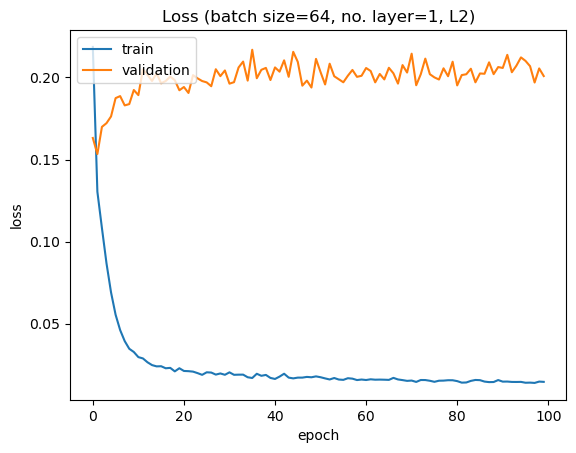

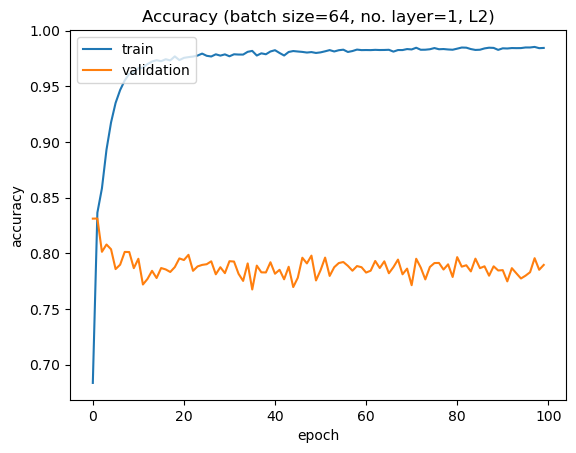

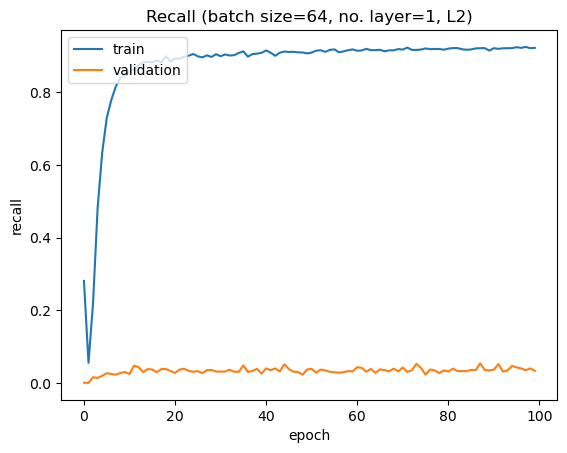

In [101]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [102]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.015
Training Accuracy: 0.984
Training Recall: 0.922


Validation Loss: 0.201
Validation Accuracy: 0.79


### batch size = 16, number of layer = 2

In [103]:
def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),
        
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu')
        
    ])
    
    return model

def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L2_augmented\\vgg_{}_2_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L2_augmented\\vgg_{}_2_{}.png".format(batch_size, metric))
    plt.show()

In [104]:
batch_size = 16
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
2400/2400 - 2s - loss: 0.1605 - accuracy: 0.8001 - recall_21: 0.0534 - val_loss: 0.1398 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00
Epoch 2/100
2400/2400 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00
Epoch 3/100
2400/2400 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00
Epoch 4/100
2400/2400 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00
Epoch 5/100
2400/2400 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00
Epoch 6/100
2400/2400 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1390 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00
Epoch 7/100
2400/2400 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_21: 

Epoch 54/100
2400/2400 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00
Epoch 55/100
2400/2400 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00
Epoch 56/100
2400/2400 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00
Epoch 57/100
2400/2400 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00
Epoch 58/100
2400/2400 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00
Epoch 59/100
2400/2400 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00
Epoch 60/100
2400/2400 - 2s - loss: 0.1389 - accuracy: 0.8333 - 

#### Predict

In [105]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

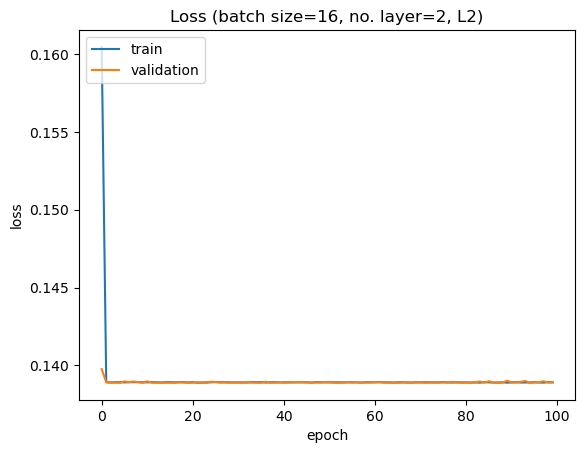

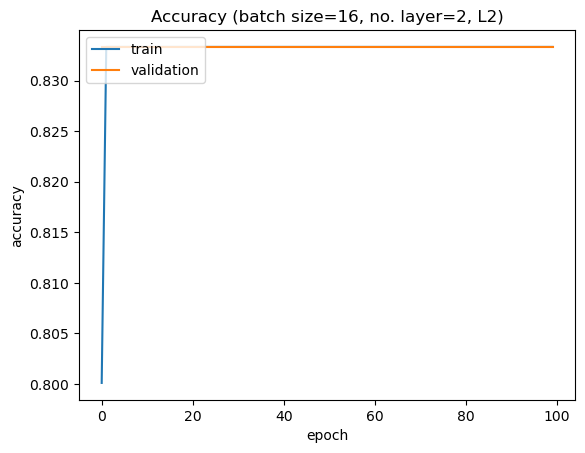

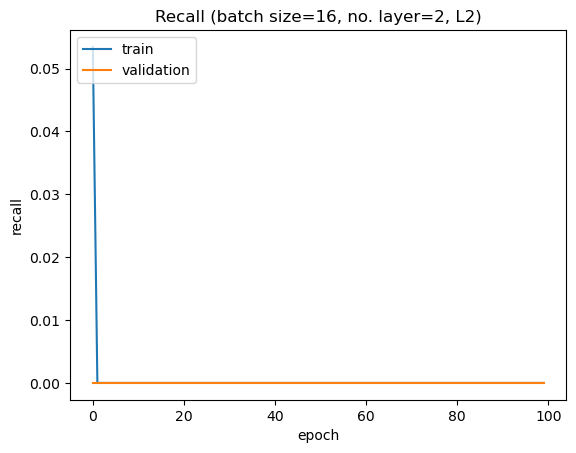

In [106]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [107]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.139
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.139
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 32, number of layer = 2

In [108]:
batch_size = 32
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
1200/1200 - 1s - loss: 0.1797 - accuracy: 0.7711 - recall_22: 0.0916 - val_loss: 0.1552 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00
Epoch 2/100
1200/1200 - 1s - loss: 0.1394 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1390 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00
Epoch 3/100
1200/1200 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1390 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00
Epoch 4/100
1200/1200 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00
Epoch 5/100
1200/1200 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00
Epoch 6/100
1200/1200 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1390 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00
Epoch 7/100
1200/1200 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_22: 

Epoch 54/100
1200/1200 - 1s - loss: 0.1381 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1404 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00
Epoch 55/100
1200/1200 - 1s - loss: 0.1380 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1403 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00
Epoch 56/100
1200/1200 - 1s - loss: 0.1379 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1404 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00
Epoch 57/100
1200/1200 - 1s - loss: 0.1378 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1404 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00
Epoch 58/100
1200/1200 - 1s - loss: 0.1378 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1404 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00
Epoch 59/100
1200/1200 - 1s - loss: 0.1379 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1404 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00
Epoch 60/100
1200/1200 - 1s - loss: 0.1377 - accuracy: 0.8333 - 

#### Predict

In [109]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

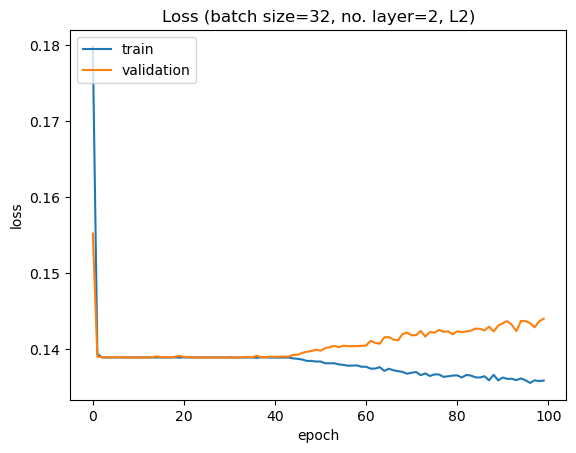

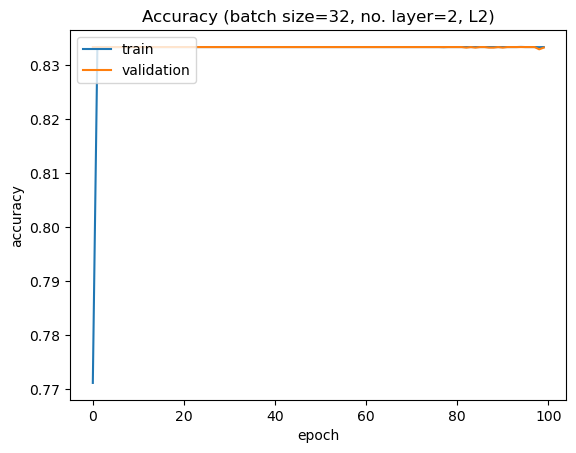

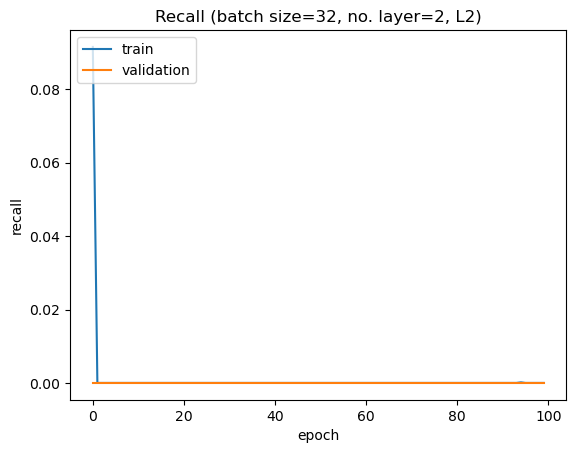

In [110]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [111]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.136
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.144
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 64, number of layer = 2

In [112]:
batch_size = 64
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 1s - loss: 0.2071 - accuracy: 0.7204 - recall_23: 0.1677 - val_loss: 0.1403 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00
Epoch 2/100
600/600 - 1s - loss: 0.1497 - accuracy: 0.8322 - recall_23: 0.0016 - val_loss: 0.1395 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00
Epoch 3/100
600/600 - 1s - loss: 0.1393 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1391 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00
Epoch 4/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1391 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00
Epoch 5/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1391 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00
Epoch 6/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00
Epoch 7/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_l

Epoch 55/100
600/600 - 1s - loss: 0.1329 - accuracy: 0.8332 - recall_23: 0.0023 - val_loss: 0.1476 - val_accuracy: 0.8331 - val_recall_23: 6.2500e-04
Epoch 56/100
600/600 - 1s - loss: 0.1330 - accuracy: 0.8333 - recall_23: 0.0033 - val_loss: 0.1454 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00
Epoch 57/100
600/600 - 1s - loss: 0.1330 - accuracy: 0.8334 - recall_23: 0.0030 - val_loss: 0.1462 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00
Epoch 58/100
600/600 - 1s - loss: 0.1331 - accuracy: 0.8330 - recall_23: 0.0036 - val_loss: 0.1449 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00
Epoch 59/100
600/600 - 1s - loss: 0.1328 - accuracy: 0.8331 - recall_23: 0.0025 - val_loss: 0.1452 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00
Epoch 60/100
600/600 - 1s - loss: 0.1326 - accuracy: 0.8330 - recall_23: 0.0022 - val_loss: 0.1448 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00
Epoch 61/100
600/600 - 1s - loss: 0.1328 - accuracy: 0.8333 - recall_23: 0.0030 - val_loss: 0.1456 -

#### Predict

In [113]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

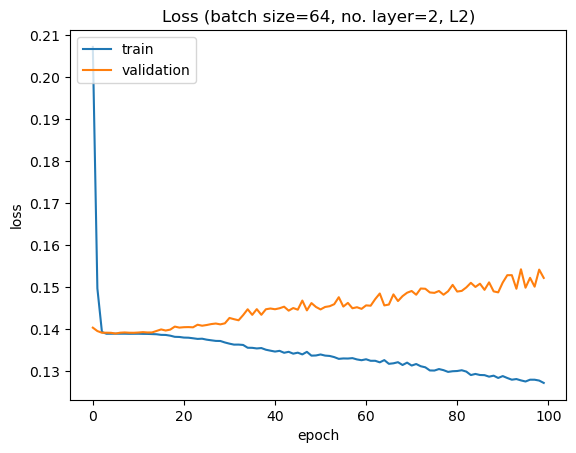

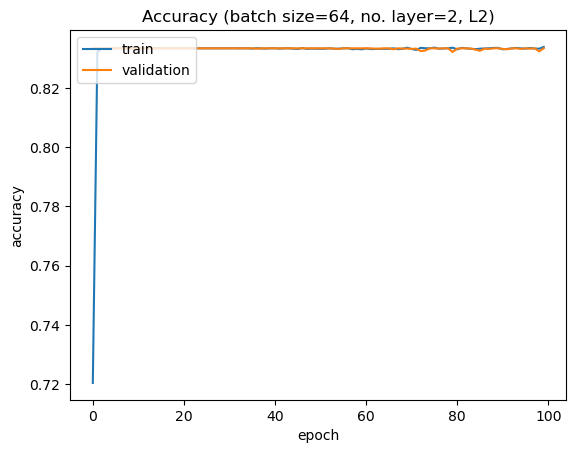

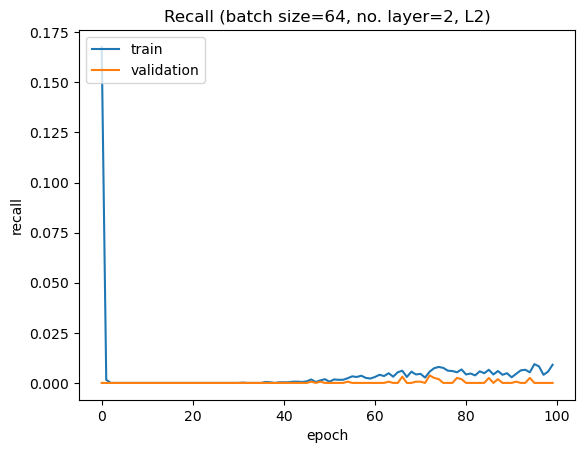

In [114]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [115]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.127
Training Accuracy: 0.834
Training Recall: 0.009


Validation Loss: 0.152
Validation Accuracy: 0.833
Validation Recall: 0.0


## resnet

In [116]:
# left_train = np.load('vgg_train_left.npy')
# left_train_augmented = np.load('AUG_vgg_train_left.npy')
# left_train = np.concatenate((left_train, left_train_augmented))
# right_train = np.load('vgg_train_right.npy')
# left_test = np.load('vgg_test_left.npy')
# right_test = np.load('vgg_test_right.npy')

left_train = np.load('resnet_train_left.npy')
left_train_augmented = np.load('AUG_resnet_train_left.npy')
left_train = np.concatenate((left_train, left_train_augmented))
right_train = np.load('resnet_train_right.npy')
left_test = np.load('resnet_test_left.npy')
right_test = np.load('resnet_test_right.npy')

# left_train = np.load('densenet_train_left.npy')
# left_train_augmented = np.load('AUG_densenet_train_left.npy')
# left_train = np.concatenate((left_train, left_train_augmented))
# right_train = np.load('densenet_train_right.npy')
# left_test = np.load('densenet_test_left.npy')
# right_test = np.load('densenet_test_right.npy')

In [117]:
left_array_dict = {}
right_array_dict = {}
for i in range(len(ground_truth)):
    left_array_dict[ground_truth['left'][i]] = left_train[i]
    if i%4 == 0:
        right_array_dict[ground_truth['right'][i//4]] = right_train[i//4]

pairs_for_training = []
for i in range(len(paired_data)):
    pairs_for_training.append([left_array_dict.get(paired_data[i][0]) , right_array_dict.get(paired_data[i][1])])
    
pairs_for_training = np.array(pairs_for_training)

left_images = pairs_for_training[:, 0]
right_images = pairs_for_training[:, 1]



test_candidates = pd.read_csv('.\COMP90086_2023_TLLdataset\\test_candidates.csv')

path = ".\COMP90086_2023_TLLdataset\\test\\left"
dir_list = os.listdir(path)
test_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\test\\right"
dir_list = os.listdir(path)
test_right_images_list = dir_list

left_array_dict = {}
for i in range(len(test_left_images_list)):
    left_array_dict[test_left_images_list[i][:3]] = left_test[i]
    
right_array_dict = {}
for i in range(len(test_right_images_list)):
    right_array_dict[test_right_images_list[i][:3]] = right_test[i]
    
pairs_for_test = []
for j in range(len(test_candidates)):
    for i in range(20):
        pairs_for_test.append([left_array_dict.get(test_candidates.iloc[j][0]) , right_array_dict.get(test_candidates.iloc[j][i+1])])

pairs_for_test = np.array(pairs_for_test)

x_test_1 = pairs_for_test[:, 0]
x_test_2 = pairs_for_test[:, 1]

### batch size = 16, number of layer = 1

In [118]:
# input_shape = (512,)
input_shape = (2048,)
# input_shape = (1024,)

def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(64, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L2_augmented\\resnet_{}_1_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L2_augmented\\resnet_{}_1_{}.png".format(batch_size, metric))
    plt.show()

In [119]:
batch_size = 16
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
2400/2400 - 5s - loss: 0.1597 - accuracy: 0.8060 - recall_24: 0.0500 - val_loss: 0.1408 - val_accuracy: 0.8333 - val_recall_24: 0.0000e+00
Epoch 2/100
2400/2400 - 5s - loss: 0.1349 - accuracy: 0.8333 - recall_24: 0.0000e+00 - val_loss: 0.1473 - val_accuracy: 0.8333 - val_recall_24: 0.0000e+00
Epoch 3/100
2400/2400 - 5s - loss: 0.1185 - accuracy: 0.8418 - recall_24: 0.1133 - val_loss: 0.1639 - val_accuracy: 0.8096 - val_recall_24: 0.0094
Epoch 4/100
2400/2400 - 5s - loss: 0.0981 - accuracy: 0.8693 - recall_24: 0.3817 - val_loss: 0.1769 - val_accuracy: 0.7915 - val_recall_24: 0.0369
Epoch 5/100
2400/2400 - 5s - loss: 0.0816 - accuracy: 0.8927 - recall_24: 0.5362 - val_loss: 0.1895 - val_accuracy: 0.7725 - val_recall_24: 0.0450
Epoch 6/100
2400/2400 - 5s - loss: 0.0723 - accuracy: 0.9059 - recall_24: 0.6181 - val_loss: 0.1857 - val_accuracy: 0.7884 - val_recall_24: 0.0275
Epoch 7/100
2400/2400 - 5s - loss: 0.0658 - accuracy: 0.9131 - recall_24: 0.6636 - val_loss: 0.1887 - val_

Epoch 57/100
2400/2400 - 5s - loss: 0.0272 - accuracy: 0.9655 - recall_24: 0.8841 - val_loss: 0.2003 - val_accuracy: 0.7825 - val_recall_24: 0.0319
Epoch 58/100
2400/2400 - 5s - loss: 0.0260 - accuracy: 0.9679 - recall_24: 0.8956 - val_loss: 0.2014 - val_accuracy: 0.7799 - val_recall_24: 0.0519
Epoch 59/100
2400/2400 - 5s - loss: 0.0265 - accuracy: 0.9667 - recall_24: 0.8927 - val_loss: 0.2022 - val_accuracy: 0.7796 - val_recall_24: 0.0475
Epoch 60/100
2400/2400 - 5s - loss: 0.0259 - accuracy: 0.9672 - recall_24: 0.8927 - val_loss: 0.2011 - val_accuracy: 0.7811 - val_recall_24: 0.0506
Epoch 61/100
2400/2400 - 5s - loss: 0.0248 - accuracy: 0.9688 - recall_24: 0.8953 - val_loss: 0.2018 - val_accuracy: 0.7812 - val_recall_24: 0.0413
Epoch 62/100
2400/2400 - 5s - loss: 0.0258 - accuracy: 0.9673 - recall_24: 0.8878 - val_loss: 0.2001 - val_accuracy: 0.7842 - val_recall_24: 0.0381
Epoch 63/100
2400/2400 - 5s - loss: 0.0261 - accuracy: 0.9670 - recall_24: 0.8922 - val_loss: 0.1963 - val_accur

#### Predict

In [120]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

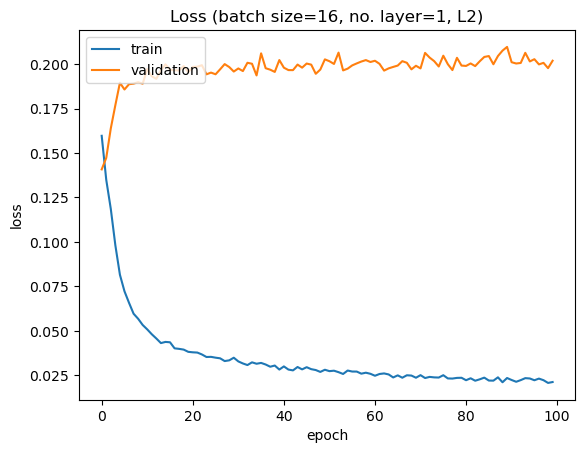

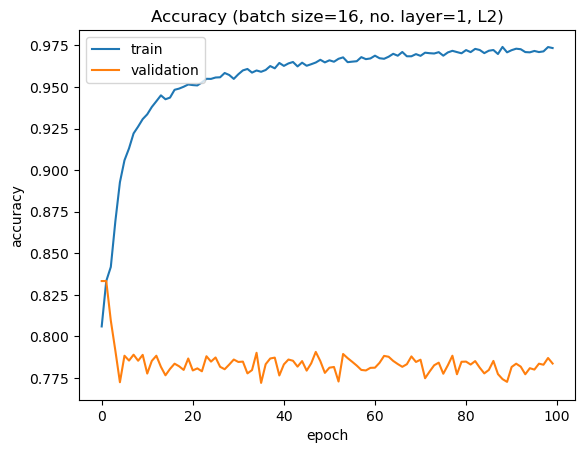

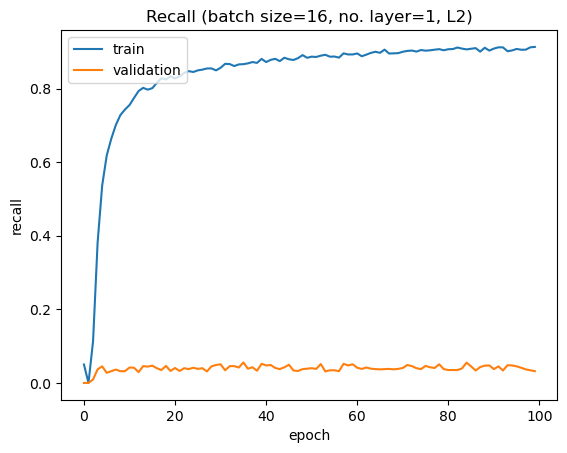

In [121]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [122]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.021
Training Accuracy: 0.973
Training Recall: 0.913


Validation Loss: 0.202
Validation Accuracy: 0.784
Validation Recall: 0.032


### batch size = 32, number of layer = 1

In [123]:
batch_size = 32
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
1200/1200 - 3s - loss: 0.1767 - accuracy: 0.7852 - recall_25: 0.0867 - val_loss: 0.1423 - val_accuracy: 0.8333 - val_recall_25: 0.0000e+00
Epoch 2/100
1200/1200 - 3s - loss: 0.1366 - accuracy: 0.8333 - recall_25: 0.0000e+00 - val_loss: 0.1444 - val_accuracy: 0.8333 - val_recall_25: 0.0000e+00
Epoch 3/100
1200/1200 - 3s - loss: 0.1328 - accuracy: 0.8334 - recall_25: 0.0011 - val_loss: 0.1536 - val_accuracy: 0.8298 - val_recall_25: 0.0025
Epoch 4/100
1200/1200 - 3s - loss: 0.1263 - accuracy: 0.8352 - recall_25: 0.0416 - val_loss: 0.1629 - val_accuracy: 0.8201 - val_recall_25: 0.0044
Epoch 5/100
1200/1200 - 3s - loss: 0.1180 - accuracy: 0.8415 - recall_25: 0.1356 - val_loss: 0.1726 - val_accuracy: 0.8052 - val_recall_25: 0.0175
Epoch 6/100
1200/1200 - 3s - loss: 0.1095 - accuracy: 0.8530 - recall_25: 0.2522 - val_loss: 0.1814 - val_accuracy: 0.7956 - val_recall_25: 0.0125
Epoch 7/100
1200/1200 - 3s - loss: 0.1020 - accuracy: 0.8658 - recall_25: 0.3509 - val_loss: 0.1850 - val_

Epoch 57/100
1200/1200 - 3s - loss: 0.0378 - accuracy: 0.9566 - recall_25: 0.8131 - val_loss: 0.2434 - val_accuracy: 0.7407 - val_recall_25: 0.0475
Epoch 58/100
1200/1200 - 3s - loss: 0.0389 - accuracy: 0.9539 - recall_25: 0.8053 - val_loss: 0.2383 - val_accuracy: 0.7447 - val_recall_25: 0.0362
Epoch 59/100
1200/1200 - 3s - loss: 0.0356 - accuracy: 0.9592 - recall_25: 0.8208 - val_loss: 0.2377 - val_accuracy: 0.7465 - val_recall_25: 0.0425
Epoch 60/100
1200/1200 - 3s - loss: 0.0357 - accuracy: 0.9592 - recall_25: 0.8230 - val_loss: 0.2368 - val_accuracy: 0.7472 - val_recall_25: 0.0331
Epoch 61/100
1200/1200 - 3s - loss: 0.0379 - accuracy: 0.9557 - recall_25: 0.8131 - val_loss: 0.2439 - val_accuracy: 0.7384 - val_recall_25: 0.0344
Epoch 62/100
1200/1200 - 3s - loss: 0.0353 - accuracy: 0.9601 - recall_25: 0.8205 - val_loss: 0.2411 - val_accuracy: 0.7433 - val_recall_25: 0.0394
Epoch 63/100
1200/1200 - 3s - loss: 0.0367 - accuracy: 0.9570 - recall_25: 0.8145 - val_loss: 0.2390 - val_accur

#### Predict

In [124]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

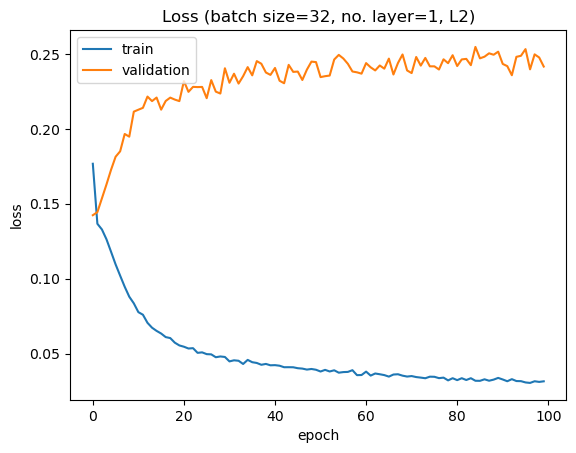

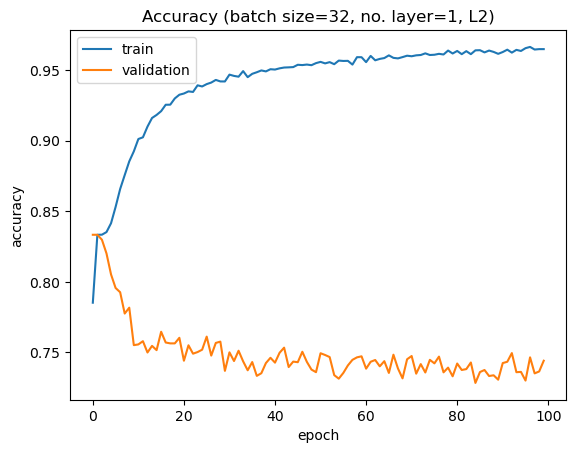

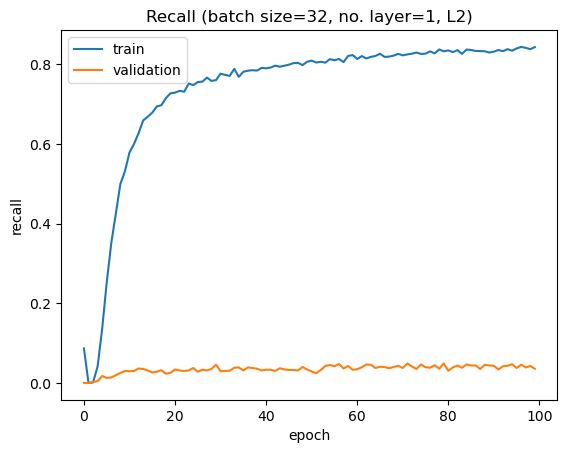

In [125]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [126]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.031
Training Accuracy: 0.965
Training Recall: 0.843


Validation Loss: 0.242
Validation Accuracy: 0.744
Validation Recall: 0.036


### batch size = 64, number of layer = 1

In [127]:
batch_size = 64
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.2051 - accuracy: 0.7462 - recall_26: 0.1378 - val_loss: 0.1582 - val_accuracy: 0.8161 - val_recall_26: 0.0188
Epoch 2/100
600/600 - 2s - loss: 0.1484 - accuracy: 0.8219 - recall_26: 0.0252 - val_loss: 0.1403 - val_accuracy: 0.8323 - val_recall_26: 0.0000e+00
Epoch 3/100
600/600 - 1s - loss: 0.1372 - accuracy: 0.8333 - recall_26: 0.0000e+00 - val_loss: 0.1441 - val_accuracy: 0.8333 - val_recall_26: 0.0000e+00
Epoch 4/100
600/600 - 1s - loss: 0.1366 - accuracy: 0.8333 - recall_26: 0.0000e+00 - val_loss: 0.1439 - val_accuracy: 0.8333 - val_recall_26: 0.0000e+00
Epoch 5/100
600/600 - 1s - loss: 0.1353 - accuracy: 0.8334 - recall_26: 1.5625e-04 - val_loss: 0.1455 - val_accuracy: 0.8332 - val_recall_26: 0.0000e+00
Epoch 6/100
600/600 - 1s - loss: 0.1339 - accuracy: 0.8332 - recall_26: 0.0017 - val_loss: 0.1488 - val_accuracy: 0.8313 - val_recall_26: 6.2500e-04
Epoch 7/100
600/600 - 1s - loss: 0.1327 - accuracy: 0.8327 - recall_26: 0.0023 - val_loss: 0.1511 

Epoch 57/100
600/600 - 1s - loss: 0.1130 - accuracy: 0.8468 - recall_26: 0.2308 - val_loss: 0.1939 - val_accuracy: 0.7635 - val_recall_26: 0.0294
Epoch 58/100
600/600 - 1s - loss: 0.1127 - accuracy: 0.8465 - recall_26: 0.2320 - val_loss: 0.1959 - val_accuracy: 0.7654 - val_recall_26: 0.0237
Epoch 59/100
600/600 - 1s - loss: 0.1124 - accuracy: 0.8469 - recall_26: 0.2330 - val_loss: 0.1902 - val_accuracy: 0.7780 - val_recall_26: 0.0250
Epoch 60/100
600/600 - 1s - loss: 0.1126 - accuracy: 0.8468 - recall_26: 0.2356 - val_loss: 0.1955 - val_accuracy: 0.7678 - val_recall_26: 0.0344
Epoch 61/100
600/600 - 1s - loss: 0.1127 - accuracy: 0.8482 - recall_26: 0.2359 - val_loss: 0.1977 - val_accuracy: 0.7632 - val_recall_26: 0.0319
Epoch 62/100
600/600 - 1s - loss: 0.1125 - accuracy: 0.8464 - recall_26: 0.2387 - val_loss: 0.2057 - val_accuracy: 0.7494 - val_recall_26: 0.0463
Epoch 63/100
600/600 - 1s - loss: 0.1124 - accuracy: 0.8473 - recall_26: 0.2334 - val_loss: 0.2046 - val_accuracy: 0.7501 - 

#### Predict

In [128]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

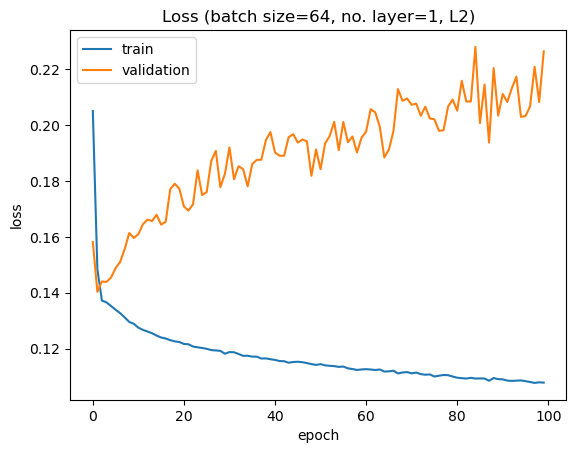

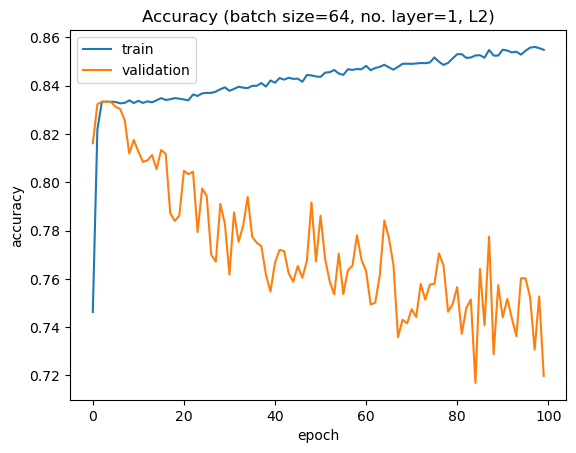

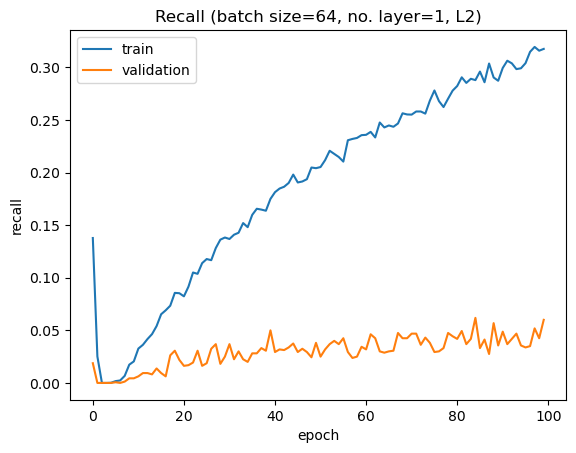

In [129]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [130]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.108
Training Accuracy: 0.855
Training Recall: 0.318


Validation Loss: 0.226
Validation Accuracy: 0.72
Validation Recall: 0.06


### batch size = 16, number of layer = 2

In [131]:
def create_shared_network(input_shape):
    model = keras.Sequential([
        
    keras.Input(shape=input_shape),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L2_augmented\\resnet_{}_2_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L2_augmented\\resnet_{}_2_{}.png".format(batch_size, metric))
    plt.show()

In [132]:
batch_size = 16
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
2400/2400 - 5s - loss: 0.1616 - accuracy: 0.7934 - recall_27: 0.0589 - val_loss: 0.1391 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00
Epoch 2/100
2400/2400 - 5s - loss: 0.1389 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00
Epoch 3/100
2400/2400 - 5s - loss: 0.1389 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00
Epoch 4/100
2400/2400 - 5s - loss: 0.1389 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00
Epoch 5/100
2400/2400 - 5s - loss: 0.1389 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00
Epoch 6/100
2400/2400 - 5s - loss: 0.1389 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00
Epoch 7/100
2400/2400 - 5s - loss: 0.1389 - accuracy: 0.8333 - recall_27: 

Epoch 54/100
2400/2400 - 4s - loss: 0.1363 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1424 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00
Epoch 55/100
2400/2400 - 5s - loss: 0.1361 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1434 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00
Epoch 56/100
2400/2400 - 5s - loss: 0.1359 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1437 - val_accuracy: 0.8332 - val_recall_27: 0.0000e+00
Epoch 57/100
2400/2400 - 5s - loss: 0.1358 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1437 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00
Epoch 58/100
2400/2400 - 5s - loss: 0.1356 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1440 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00
Epoch 59/100
2400/2400 - 5s - loss: 0.1357 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1436 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00
Epoch 60/100
2400/2400 - 5s - loss: 0.1355 - accuracy: 0.8333 - 

#### Predict

In [133]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

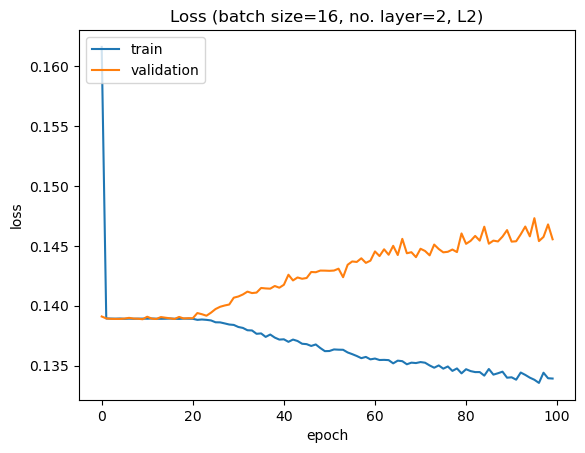

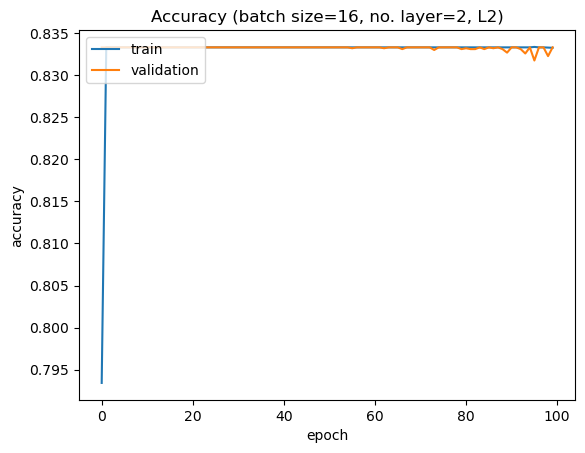

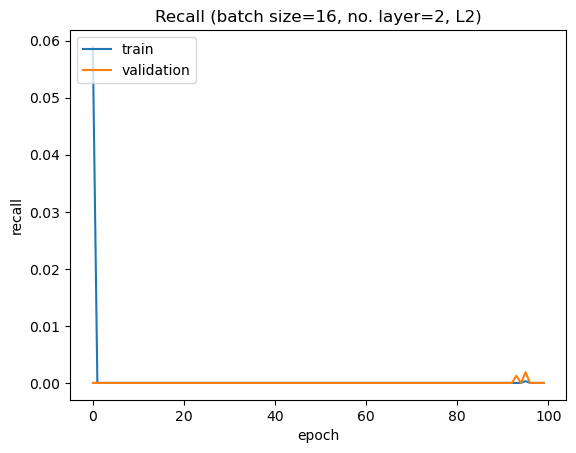

In [134]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [135]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.134
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.146
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 32, number of layer = 2

In [136]:
batch_size = 32
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
1200/1200 - 3s - loss: 0.1794 - accuracy: 0.7727 - recall_28: 0.0959 - val_loss: 0.1394 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00
Epoch 2/100
1200/1200 - 3s - loss: 0.1393 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1390 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00
Epoch 3/100
1200/1200 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1390 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00
Epoch 4/100
1200/1200 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1392 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00
Epoch 5/100
1200/1200 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1390 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00
Epoch 6/100
1200/1200 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1390 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00
Epoch 7/100
1200/1200 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_28: 

Epoch 54/100
1200/1200 - 3s - loss: 0.1344 - accuracy: 0.8332 - recall_28: 4.6875e-04 - val_loss: 0.1459 - val_accuracy: 0.8332 - val_recall_28: 0.0000e+00
Epoch 55/100
1200/1200 - 3s - loss: 0.1342 - accuracy: 0.8333 - recall_28: 0.0011 - val_loss: 0.1452 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00
Epoch 56/100
1200/1200 - 3s - loss: 0.1347 - accuracy: 0.8332 - recall_28: 3.1250e-04 - val_loss: 0.1445 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00
Epoch 57/100
1200/1200 - 3s - loss: 0.1342 - accuracy: 0.8332 - recall_28: 6.2500e-04 - val_loss: 0.1446 - val_accuracy: 0.8332 - val_recall_28: 0.0000e+00
Epoch 58/100
1200/1200 - 3s - loss: 0.1341 - accuracy: 0.8331 - recall_28: 7.8125e-04 - val_loss: 0.1455 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00
Epoch 59/100
1200/1200 - 3s - loss: 0.1342 - accuracy: 0.8334 - recall_28: 0.0016 - val_loss: 0.1455 - val_accuracy: 0.8332 - val_recall_28: 0.0000e+00
Epoch 60/100
1200/1200 - 3s - loss: 0.1340 - accuracy: 0.8332 - recall_2

#### Predict

In [137]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

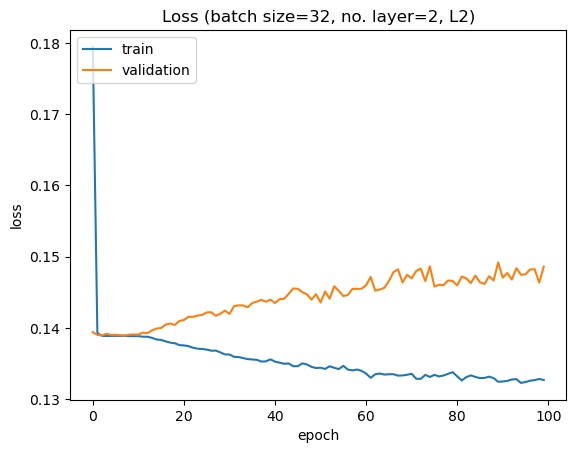

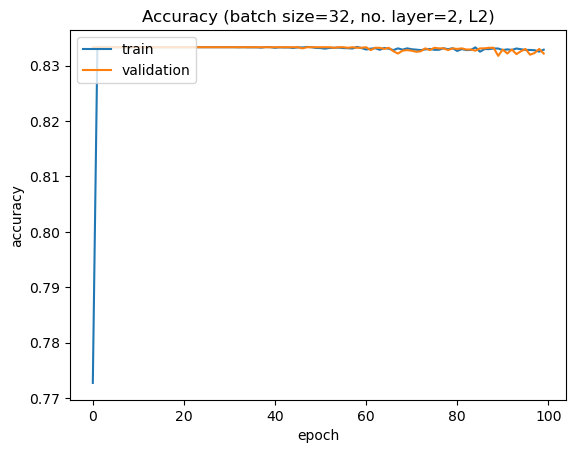

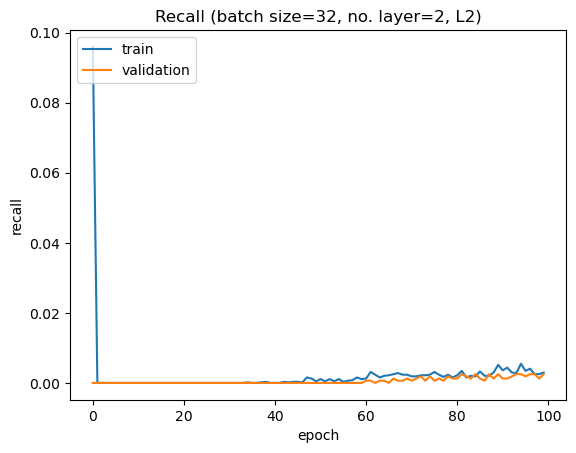

In [138]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [139]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.133
Training Accuracy: 0.833
Training Recall: 0.003


Validation Loss: 0.149
Validation Accuracy: 0.832
Validation Recall: 0.002


### batch size = 64, number of layer = 2

In [140]:
batch_size = 64
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.2050 - accuracy: 0.7799 - recall_29: 0.0759 - val_loss: 0.1894 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00
Epoch 2/100
600/600 - 2s - loss: 0.1457 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1402 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00
Epoch 3/100
600/600 - 2s - loss: 0.1390 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00
Epoch 4/100
600/600 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00
Epoch 5/100
600/600 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00
Epoch 6/100
600/600 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1390 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00
Epoch 7/100
600/600 - 2s - loss: 0.1388 - accuracy: 0.8333 - recall_29: 0.0000e+00 - v

Epoch 55/100
600/600 - 2s - loss: 0.1250 - accuracy: 0.8332 - recall_29: 0.0047 - val_loss: 0.1612 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00
Epoch 56/100
600/600 - 2s - loss: 0.1249 - accuracy: 0.8330 - recall_29: 0.0061 - val_loss: 0.1644 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00
Epoch 57/100
600/600 - 2s - loss: 0.1244 - accuracy: 0.8334 - recall_29: 0.0081 - val_loss: 0.1634 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00
Epoch 58/100
600/600 - 2s - loss: 0.1246 - accuracy: 0.8334 - recall_29: 0.0088 - val_loss: 0.1653 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00
Epoch 59/100
600/600 - 2s - loss: 0.1243 - accuracy: 0.8331 - recall_29: 0.0113 - val_loss: 0.1652 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00
Epoch 60/100
600/600 - 2s - loss: 0.1235 - accuracy: 0.8341 - recall_29: 0.0189 - val_loss: 0.1671 - val_accuracy: 0.8332 - val_recall_29: 6.2500e-04
Epoch 61/100
600/600 - 2s - loss: 0.1233 - accuracy: 0.8335 - recall_29: 0.0164 - val_loss: 0.1669 -

#### Predict

In [141]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

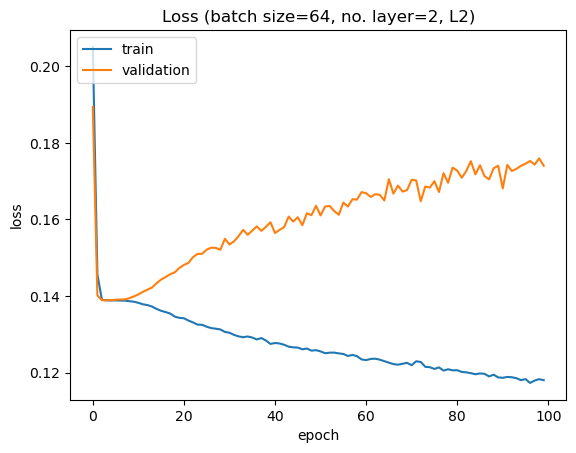

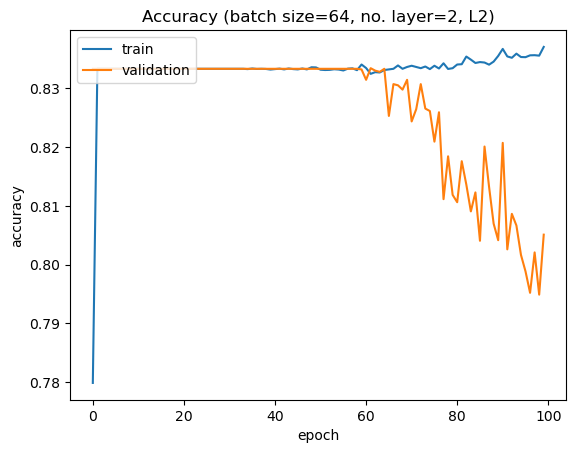

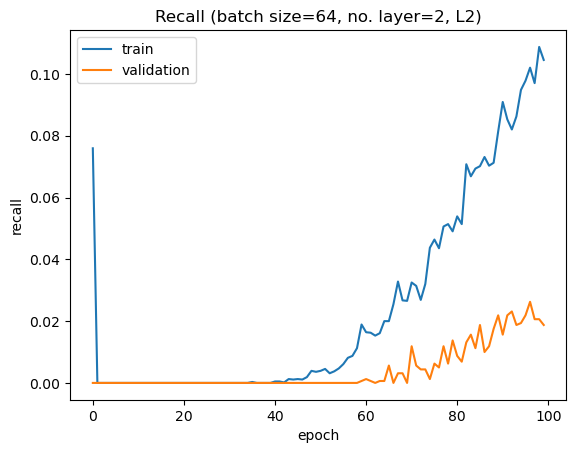

In [142]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [143]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.118
Training Accuracy: 0.837
Training Recall: 0.105


Validation Loss: 0.174
Validation Accuracy: 0.805
Validation Recall: 0.019


## densenet

In [144]:
# left_train = np.load('vgg_train_left.npy')
# left_train_augmented = np.load('AUG_vgg_train_left.npy')
# left_train = np.concatenate((left_train, left_train_augmented))
# right_train = np.load('vgg_train_right.npy')
# left_test = np.load('vgg_test_left.npy')
# right_test = np.load('vgg_test_right.npy')

# left_train = np.load('resnet_train_left.npy')
# left_train_augmented = np.load('AUG_resnet_train_left.npy')
# left_train = np.concatenate((left_train, left_train_augmented))
# right_train = np.load('resnet_train_right.npy')
# left_test = np.load('resnet_test_left.npy')
# right_test = np.load('resnet_test_right.npy')

left_train = np.load('densenet_train_left.npy')
left_train_augmented = np.load('AUG_densenet_train_left.npy')
left_train = np.concatenate((left_train, left_train_augmented))
right_train = np.load('densenet_train_right.npy')
left_test = np.load('densenet_test_left.npy')
right_test = np.load('densenet_test_right.npy')

In [145]:
left_array_dict = {}
right_array_dict = {}
for i in range(len(ground_truth)):
    left_array_dict[ground_truth['left'][i]] = left_train[i]
    if i%4 == 0:
        right_array_dict[ground_truth['right'][i//4]] = right_train[i//4]

pairs_for_training = []
for i in range(len(paired_data)):
    pairs_for_training.append([left_array_dict.get(paired_data[i][0]) , right_array_dict.get(paired_data[i][1])])
    
pairs_for_training = np.array(pairs_for_training)

left_images = pairs_for_training[:, 0]
right_images = pairs_for_training[:, 1]



test_candidates = pd.read_csv('.\COMP90086_2023_TLLdataset\\test_candidates.csv')

path = ".\COMP90086_2023_TLLdataset\\test\\left"
dir_list = os.listdir(path)
test_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\test\\right"
dir_list = os.listdir(path)
test_right_images_list = dir_list

left_array_dict = {}
for i in range(len(test_left_images_list)):
    left_array_dict[test_left_images_list[i][:3]] = left_test[i]
    
right_array_dict = {}
for i in range(len(test_right_images_list)):
    right_array_dict[test_right_images_list[i][:3]] = right_test[i]
    
pairs_for_test = []
for j in range(len(test_candidates)):
    for i in range(20):
        pairs_for_test.append([left_array_dict.get(test_candidates.iloc[j][0]) , right_array_dict.get(test_candidates.iloc[j][i+1])])

pairs_for_test = np.array(pairs_for_test)

x_test_1 = pairs_for_test[:, 0]
x_test_2 = pairs_for_test[:, 1]

### batch size = 16, number of layer = 1

In [146]:
# input_shape = (512,)
# input_shape = (2048,)
input_shape = (1024,)

def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(64, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L2_augmented\\densenet_{}_1_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L2_augmented\\densenet_{}_1_{}.png".format(batch_size, metric))
    plt.show()

In [147]:
batch_size = 16
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
2400/2400 - 3s - loss: 0.1574 - accuracy: 0.7980 - recall_30: 0.0620 - val_loss: 0.1447 - val_accuracy: 0.8333 - val_recall_30: 0.0000e+00
Epoch 2/100
2400/2400 - 3s - loss: 0.1268 - accuracy: 0.8359 - recall_30: 0.0303 - val_loss: 0.1580 - val_accuracy: 0.8270 - val_recall_30: 0.0075
Epoch 3/100
2400/2400 - 3s - loss: 0.1096 - accuracy: 0.8542 - recall_30: 0.2486 - val_loss: 0.1701 - val_accuracy: 0.8093 - val_recall_30: 0.0181
Epoch 4/100
2400/2400 - 3s - loss: 0.0950 - accuracy: 0.8751 - recall_30: 0.4281 - val_loss: 0.1760 - val_accuracy: 0.8025 - val_recall_30: 0.0319
Epoch 5/100
2400/2400 - 3s - loss: 0.0845 - accuracy: 0.8911 - recall_30: 0.5188 - val_loss: 0.1898 - val_accuracy: 0.7826 - val_recall_30: 0.0269
Epoch 6/100
2400/2400 - 3s - loss: 0.0790 - accuracy: 0.8984 - recall_30: 0.5752 - val_loss: 0.1882 - val_accuracy: 0.7850 - val_recall_30: 0.0431
Epoch 7/100
2400/2400 - 3s - loss: 0.0722 - accuracy: 0.9083 - recall_30: 0.6216 - val_loss: 0.1868 - val_accuracy

Epoch 57/100
2400/2400 - 3s - loss: 0.0403 - accuracy: 0.9516 - recall_30: 0.8078 - val_loss: 0.2024 - val_accuracy: 0.7824 - val_recall_30: 0.0256
Epoch 58/100
2400/2400 - 3s - loss: 0.0385 - accuracy: 0.9541 - recall_30: 0.8186 - val_loss: 0.2004 - val_accuracy: 0.7854 - val_recall_30: 0.0319
Epoch 59/100
2400/2400 - 3s - loss: 0.0389 - accuracy: 0.9530 - recall_30: 0.8202 - val_loss: 0.2081 - val_accuracy: 0.7748 - val_recall_30: 0.0362
Epoch 60/100
2400/2400 - 3s - loss: 0.0393 - accuracy: 0.9526 - recall_30: 0.8125 - val_loss: 0.1981 - val_accuracy: 0.7892 - val_recall_30: 0.0244
Epoch 61/100
2400/2400 - 3s - loss: 0.0367 - accuracy: 0.9566 - recall_30: 0.8245 - val_loss: 0.2016 - val_accuracy: 0.7836 - val_recall_30: 0.0325
Epoch 62/100
2400/2400 - 3s - loss: 0.0372 - accuracy: 0.9561 - recall_30: 0.8269 - val_loss: 0.2010 - val_accuracy: 0.7850 - val_recall_30: 0.0312
Epoch 63/100
2400/2400 - 3s - loss: 0.0391 - accuracy: 0.9530 - recall_30: 0.8147 - val_loss: 0.2119 - val_accur

#### Predict

In [148]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

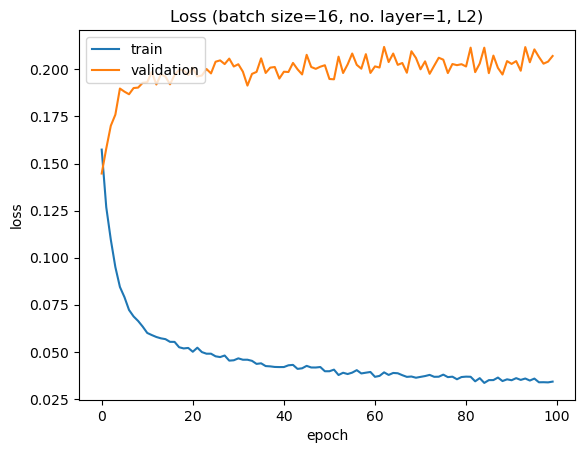

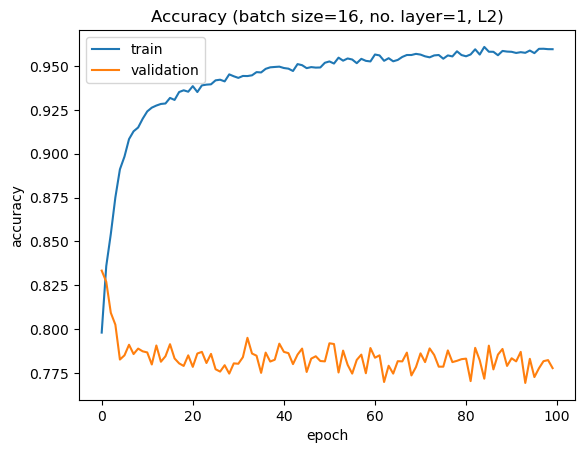

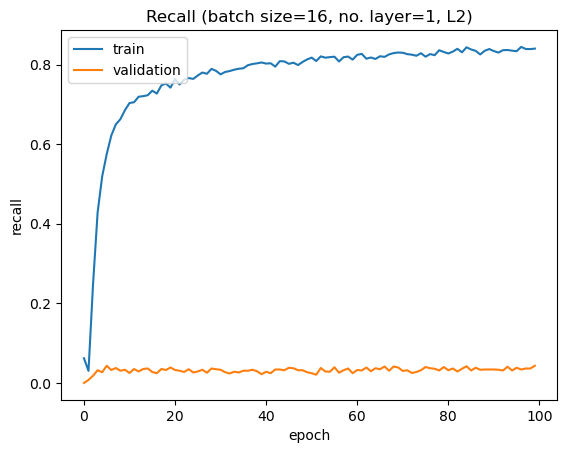

In [149]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [150]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.034
Training Accuracy: 0.96
Training Recall: 0.84


Validation Loss: 0.207
Validation Accuracy: 0.778
Validation Recall: 0.043


### batch size = 32, number of layer = 1

In [151]:
batch_size = 32
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
1200/1200 - 2s - loss: 0.1773 - accuracy: 0.7588 - recall_31: 0.1419 - val_loss: 0.1491 - val_accuracy: 0.8333 - val_recall_31: 0.0000e+00
Epoch 2/100
1200/1200 - 1s - loss: 0.1231 - accuracy: 0.8391 - recall_31: 0.0562 - val_loss: 0.1620 - val_accuracy: 0.8194 - val_recall_31: 0.0063
Epoch 3/100
1200/1200 - 1s - loss: 0.1028 - accuracy: 0.8669 - recall_31: 0.3205 - val_loss: 0.1713 - val_accuracy: 0.8075 - val_recall_31: 0.0200
Epoch 4/100
1200/1200 - 1s - loss: 0.0840 - accuracy: 0.8951 - recall_31: 0.5173 - val_loss: 0.1805 - val_accuracy: 0.7934 - val_recall_31: 0.0288
Epoch 5/100
1200/1200 - 1s - loss: 0.0715 - accuracy: 0.9102 - recall_31: 0.6091 - val_loss: 0.1888 - val_accuracy: 0.7793 - val_recall_31: 0.0456
Epoch 6/100
1200/1200 - 1s - loss: 0.0623 - accuracy: 0.9245 - recall_31: 0.6827 - val_loss: 0.1865 - val_accuracy: 0.7907 - val_recall_31: 0.0350
Epoch 7/100
1200/1200 - 1s - loss: 0.0570 - accuracy: 0.9308 - recall_31: 0.7163 - val_loss: 0.1940 - val_accuracy

Epoch 57/100
1200/1200 - 1s - loss: 0.0263 - accuracy: 0.9704 - recall_31: 0.8689 - val_loss: 0.1976 - val_accuracy: 0.7908 - val_recall_31: 0.0431
Epoch 58/100
1200/1200 - 1s - loss: 0.0257 - accuracy: 0.9708 - recall_31: 0.8655 - val_loss: 0.1950 - val_accuracy: 0.7952 - val_recall_31: 0.0344
Epoch 59/100
1200/1200 - 1s - loss: 0.0266 - accuracy: 0.9700 - recall_31: 0.8662 - val_loss: 0.1914 - val_accuracy: 0.7985 - val_recall_31: 0.0338
Epoch 60/100
1200/1200 - 1s - loss: 0.0250 - accuracy: 0.9724 - recall_31: 0.8728 - val_loss: 0.2013 - val_accuracy: 0.7861 - val_recall_31: 0.0481
Epoch 61/100
1200/1200 - 1s - loss: 0.0261 - accuracy: 0.9707 - recall_31: 0.8684 - val_loss: 0.1995 - val_accuracy: 0.7882 - val_recall_31: 0.0338
Epoch 62/100
1200/1200 - 1s - loss: 0.0254 - accuracy: 0.9716 - recall_31: 0.8711 - val_loss: 0.1954 - val_accuracy: 0.7950 - val_recall_31: 0.0338
Epoch 63/100
1200/1200 - 1s - loss: 0.0265 - accuracy: 0.9702 - recall_31: 0.8672 - val_loss: 0.1967 - val_accur

#### Predict

In [152]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

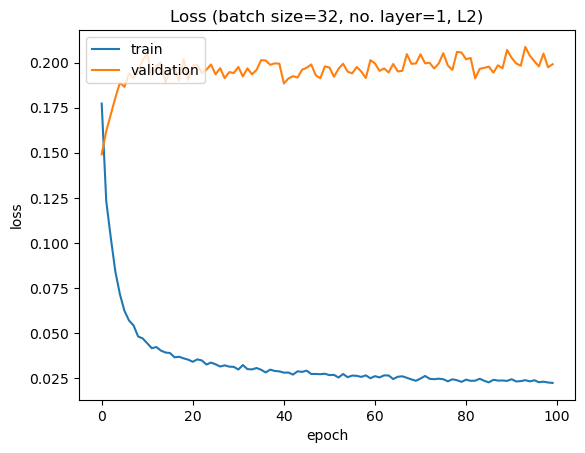

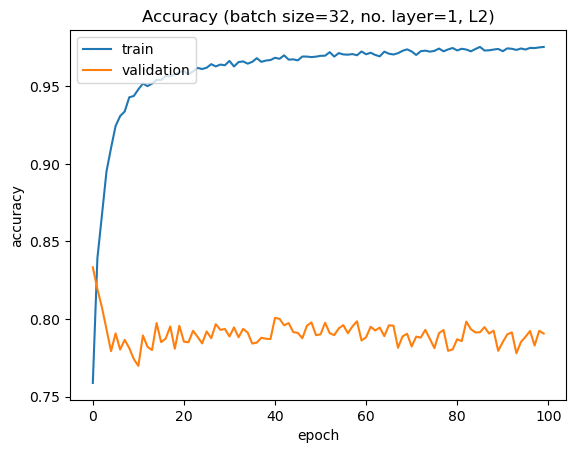

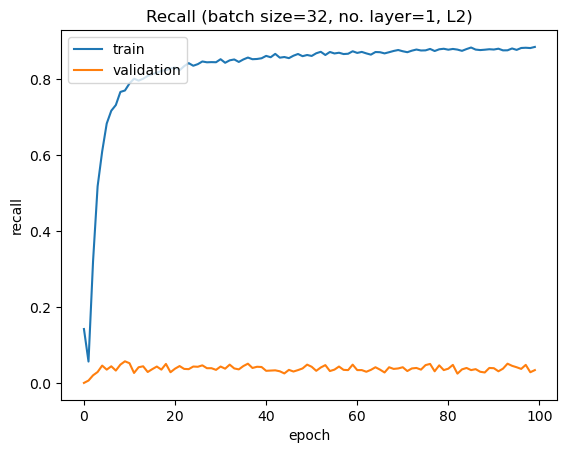

In [153]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [154]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.022
Training Accuracy: 0.975
Training Recall: 0.884


Validation Loss: 0.199
Validation Accuracy: 0.791
Validation Recall: 0.034


### batch size = 64, number of layer = 1

In [155]:
batch_size = 64
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 1s - loss: 0.2106 - accuracy: 0.6928 - recall_32: 0.3094 - val_loss: 0.1692 - val_accuracy: 0.8169 - val_recall_32: 0.0131
Epoch 2/100
600/600 - 1s - loss: 0.1248 - accuracy: 0.8424 - recall_32: 0.1142 - val_loss: 0.1566 - val_accuracy: 0.8278 - val_recall_32: 0.0050
Epoch 3/100
600/600 - 1s - loss: 0.1039 - accuracy: 0.8644 - recall_32: 0.2817 - val_loss: 0.1678 - val_accuracy: 0.8069 - val_recall_32: 0.0262
Epoch 4/100
600/600 - 1s - loss: 0.0838 - accuracy: 0.8951 - recall_32: 0.5061 - val_loss: 0.1733 - val_accuracy: 0.8058 - val_recall_32: 0.0250
Epoch 5/100
600/600 - 1s - loss: 0.0662 - accuracy: 0.9206 - recall_32: 0.6595 - val_loss: 0.1831 - val_accuracy: 0.7884 - val_recall_32: 0.0300
Epoch 6/100
600/600 - 1s - loss: 0.0553 - accuracy: 0.9340 - recall_32: 0.7280 - val_loss: 0.1768 - val_accuracy: 0.8073 - val_recall_32: 0.0262
Epoch 7/100
600/600 - 1s - loss: 0.0460 - accuracy: 0.9463 - recall_32: 0.7850 - val_loss: 0.1845 - val_accuracy: 0.7947 - val_rec

Epoch 58/100
600/600 - 1s - loss: 0.0168 - accuracy: 0.9812 - recall_32: 0.9142 - val_loss: 0.1881 - val_accuracy: 0.8058 - val_recall_32: 0.0306
Epoch 59/100
600/600 - 1s - loss: 0.0151 - accuracy: 0.9833 - recall_32: 0.9197 - val_loss: 0.1915 - val_accuracy: 0.8005 - val_recall_32: 0.0306
Epoch 60/100
600/600 - 1s - loss: 0.0151 - accuracy: 0.9837 - recall_32: 0.9202 - val_loss: 0.1935 - val_accuracy: 0.7980 - val_recall_32: 0.0362
Epoch 61/100
600/600 - 1s - loss: 0.0169 - accuracy: 0.9814 - recall_32: 0.9123 - val_loss: 0.1958 - val_accuracy: 0.7953 - val_recall_32: 0.0262
Epoch 62/100
600/600 - 1s - loss: 0.0156 - accuracy: 0.9830 - recall_32: 0.9177 - val_loss: 0.1967 - val_accuracy: 0.7933 - val_recall_32: 0.0369
Epoch 63/100
600/600 - 1s - loss: 0.0157 - accuracy: 0.9825 - recall_32: 0.9158 - val_loss: 0.1962 - val_accuracy: 0.7941 - val_recall_32: 0.0406
Epoch 64/100
600/600 - 1s - loss: 0.0154 - accuracy: 0.9829 - recall_32: 0.9177 - val_loss: 0.1913 - val_accuracy: 0.8014 - 

#### Predict

In [156]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

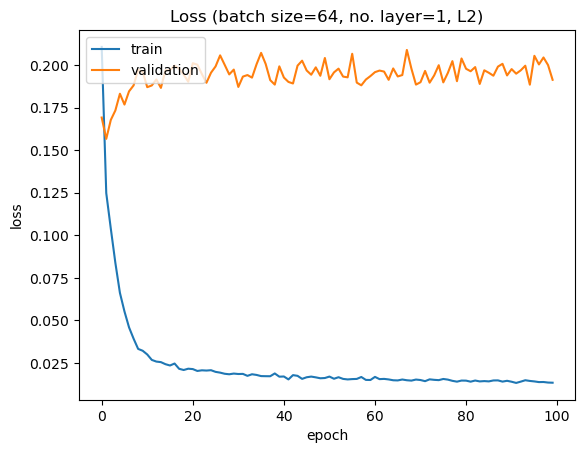

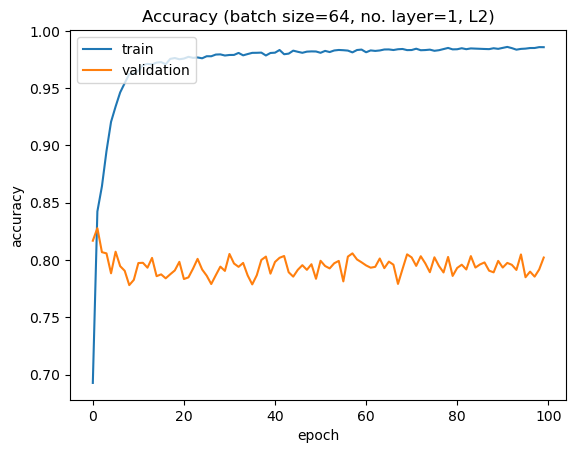

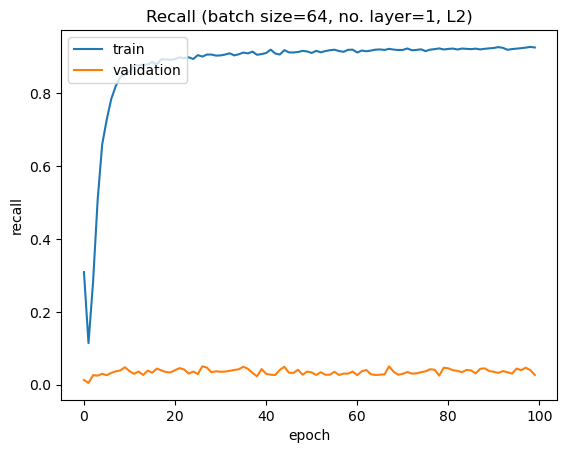

In [157]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [158]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.013
Training Accuracy: 0.986
Training Recall: 0.926


Validation Loss: 0.191
Validation Accuracy: 0.802
Validation Recall: 0.027


### batch size = 16, number of layer = 2

In [159]:
def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L2_augmented\\densenet_{}_2_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L2_augmented\\densenet_{}_2_{}.png".format(batch_size, metric))
    plt.show()

In [160]:
batch_size = 16
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
2400/2400 - 3s - loss: 0.1637 - accuracy: 0.7910 - recall_33: 0.0584 - val_loss: 0.1391 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00
Epoch 2/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1391 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00
Epoch 3/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00
Epoch 4/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1391 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00
Epoch 5/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00
Epoch 6/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1390 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00
Epoch 7/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_33: 

Epoch 54/100
2400/2400 - 3s - loss: 0.1378 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1407 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00
Epoch 55/100
2400/2400 - 3s - loss: 0.1376 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1407 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00
Epoch 56/100
2400/2400 - 3s - loss: 0.1379 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1407 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00
Epoch 57/100
2400/2400 - 3s - loss: 0.1377 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1406 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00
Epoch 58/100
2400/2400 - 3s - loss: 0.1378 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1403 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00
Epoch 59/100
2400/2400 - 3s - loss: 0.1376 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1411 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00
Epoch 60/100
2400/2400 - 3s - loss: 0.1377 - accuracy: 0.8333 - 

#### Predict

In [161]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

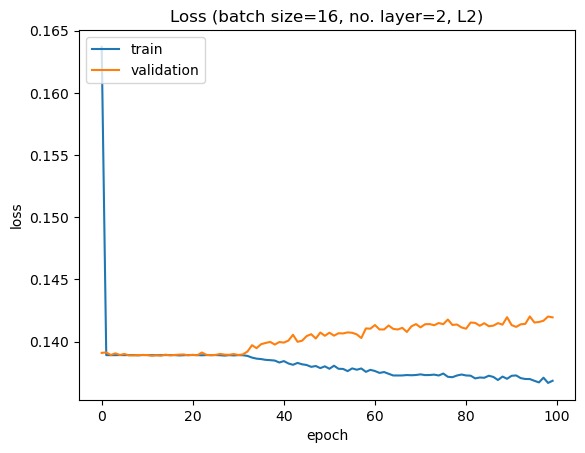

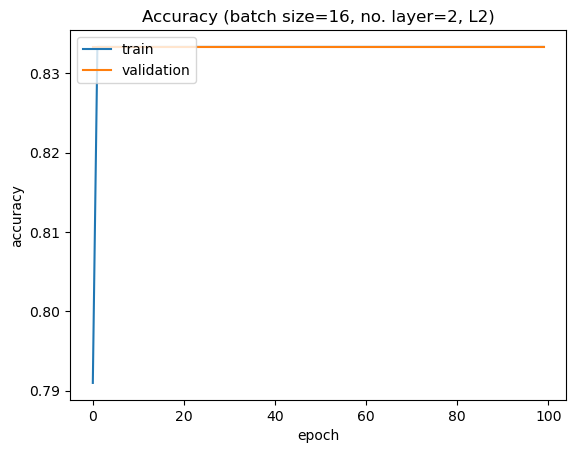

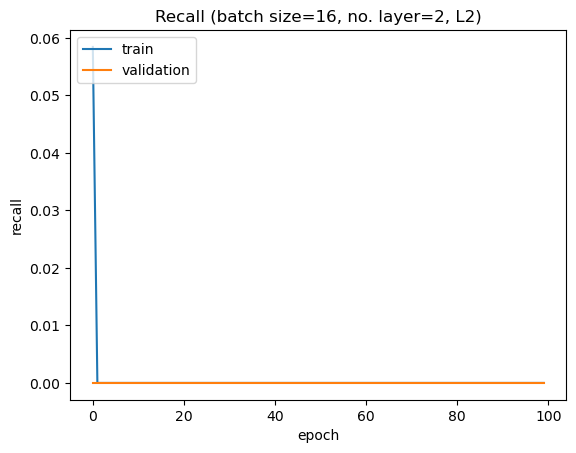

In [162]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [163]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.137
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.142
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 32, number of layer = 2

In [164]:
batch_size = 32
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
1200/1200 - 2s - loss: 0.1755 - accuracy: 0.8164 - recall_34: 0.0256 - val_loss: 0.1443 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00
Epoch 2/100
1200/1200 - 1s - loss: 0.1390 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00
Epoch 3/100
1200/1200 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00
Epoch 4/100
1200/1200 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1390 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00
Epoch 5/100
1200/1200 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00
Epoch 6/100
1200/1200 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00
Epoch 7/100
1200/1200 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_34: 

Epoch 54/100
1200/1200 - 1s - loss: 0.1330 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1522 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00
Epoch 55/100
1200/1200 - 1s - loss: 0.1324 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1525 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00
Epoch 56/100
1200/1200 - 2s - loss: 0.1326 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1520 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00
Epoch 57/100
1200/1200 - 1s - loss: 0.1325 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1527 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00
Epoch 58/100
1200/1200 - 1s - loss: 0.1323 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1531 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00
Epoch 59/100
1200/1200 - 1s - loss: 0.1323 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1520 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00
Epoch 60/100
1200/1200 - 1s - loss: 0.1321 - accuracy: 0.8333 - 

#### Predict

In [165]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

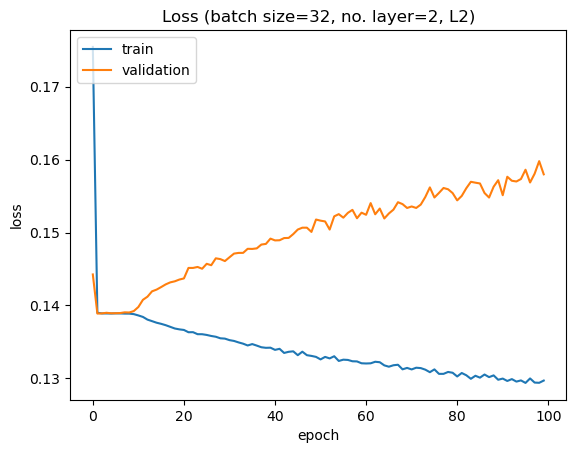

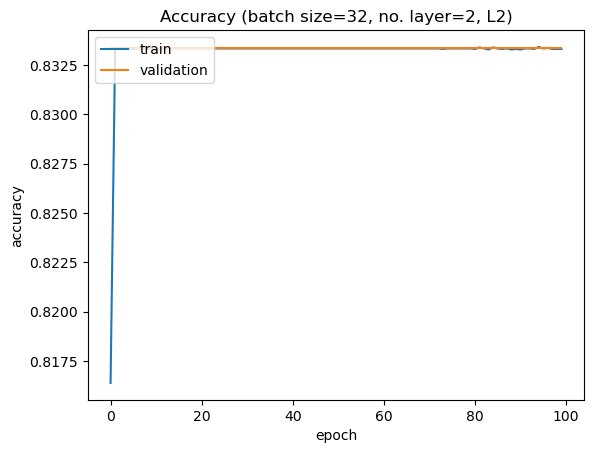

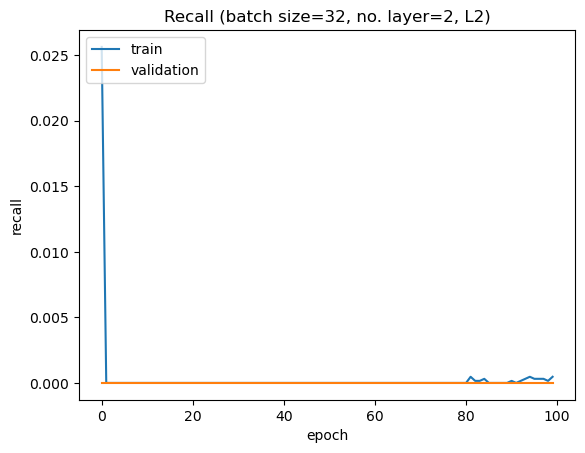

In [166]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [167]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.13
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.158
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 64, number of layer = 2

In [168]:
batch_size = 64
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 1s - loss: 0.2064 - accuracy: 0.7373 - recall_35: 0.1430 - val_loss: 0.1400 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00
Epoch 2/100
600/600 - 1s - loss: 0.1490 - accuracy: 0.8327 - recall_35: 7.8125e-04 - val_loss: 0.1401 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00
Epoch 3/100
600/600 - 1s - loss: 0.1393 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1393 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00
Epoch 4/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1390 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00
Epoch 5/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1391 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00
Epoch 6/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1393 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00
Epoch 7/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_35: 0.0000e+00 - v

Epoch 55/100
600/600 - 1s - loss: 0.1327 - accuracy: 0.8329 - recall_35: 0.0050 - val_loss: 0.1480 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00
Epoch 56/100
600/600 - 1s - loss: 0.1325 - accuracy: 0.8330 - recall_35: 0.0059 - val_loss: 0.1498 - val_accuracy: 0.8327 - val_recall_35: 0.0000e+00
Epoch 57/100
600/600 - 1s - loss: 0.1325 - accuracy: 0.8330 - recall_35: 0.0070 - val_loss: 0.1493 - val_accuracy: 0.8329 - val_recall_35: 0.0000e+00
Epoch 58/100
600/600 - 1s - loss: 0.1322 - accuracy: 0.8325 - recall_35: 0.0053 - val_loss: 0.1495 - val_accuracy: 0.8328 - val_recall_35: 0.0000e+00
Epoch 59/100
600/600 - 1s - loss: 0.1323 - accuracy: 0.8332 - recall_35: 0.0073 - val_loss: 0.1498 - val_accuracy: 0.8329 - val_recall_35: 0.0000e+00
Epoch 60/100
600/600 - 1s - loss: 0.1321 - accuracy: 0.8330 - recall_35: 0.0081 - val_loss: 0.1501 - val_accuracy: 0.8330 - val_recall_35: 0.0000e+00
Epoch 61/100
600/600 - 1s - loss: 0.1317 - accuracy: 0.8323 - recall_35: 0.0073 - val_loss: 0.1527 -

#### Predict

In [169]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

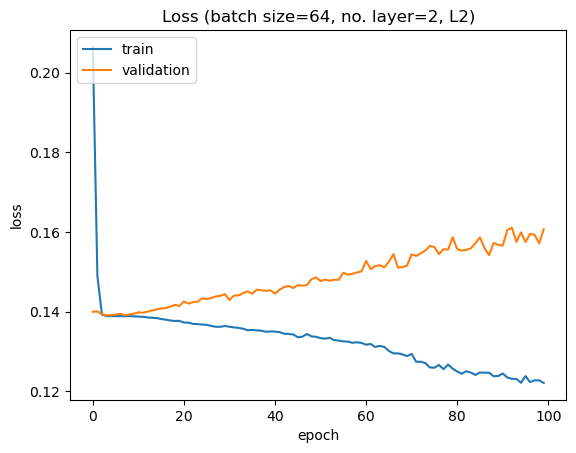

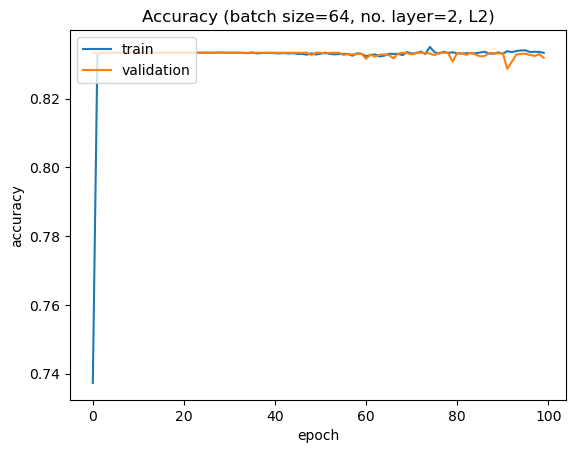

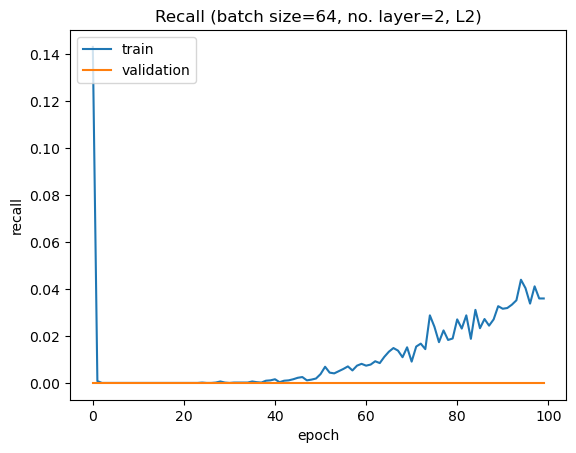

In [170]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [171]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.122
Training Accuracy: 0.833
Training Recall: 0.036


Validation Loss: 0.161
Validation Accuracy: 0.832
Validation Recall: 0.0
